# 프로젝트 : Segmentation map으로 도로 이미지 만들기

이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과입니다.

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다.  
데이터셋은 아래에서 다운로드 할 수 있습니다.  
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.  

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.

아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해봅시다.  
(아래 튜토리얼은 Pix2Pix 구조를 Functional API를 이용해 구현하기 때문에 이번에 진행한 Subclassing 방법을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)  

https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko

프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 1 가지 이상의 augmentation 방법을 적용하여 학습해주세요. (어떠한 방법을 사용했는지 적어주세요).

2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.

3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내에서 아무 이미지나 사용해주세요.
1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 (스케치, 생성된 사진, 실제 사진) 순서로 나란히 시각화해 주세요.

4. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

In [1]:
import os
train_data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'

In [2]:
print("number of train examples :", len(os.listdir(train_data_path)))

number of train examples : 1000


In [3]:
val_data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

In [4]:
print("number of val examples :", len(os.listdir(val_data_path)))

number of val examples : 5


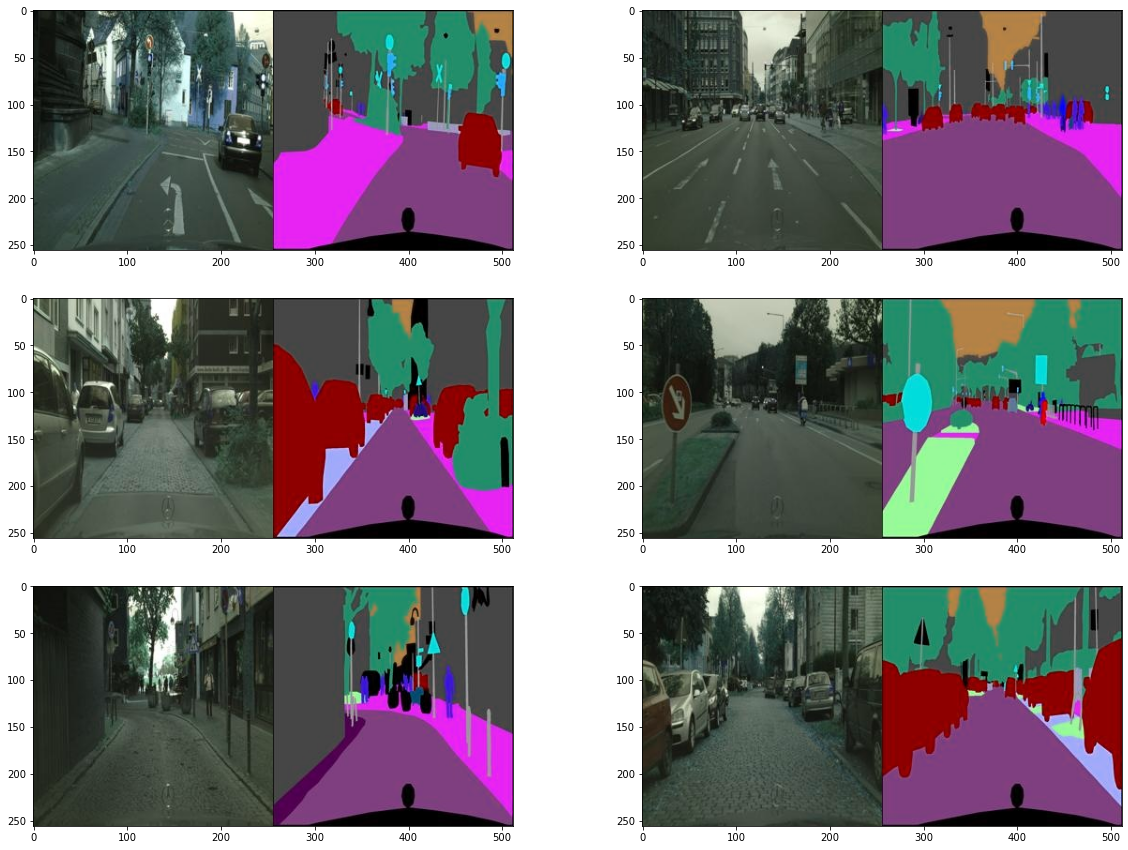

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [6]:
f = train_data_path + os.listdir(train_data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [7]:
f_val = val_data_path + os.listdir(val_data_path)[0]
img_val = cv2.imread(f_val, cv2.IMREAD_COLOR)
print(img_val.shape)

(256, 512, 3)


In [8]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


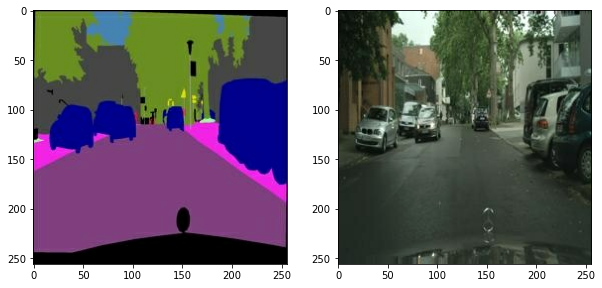

In [9]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [10]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


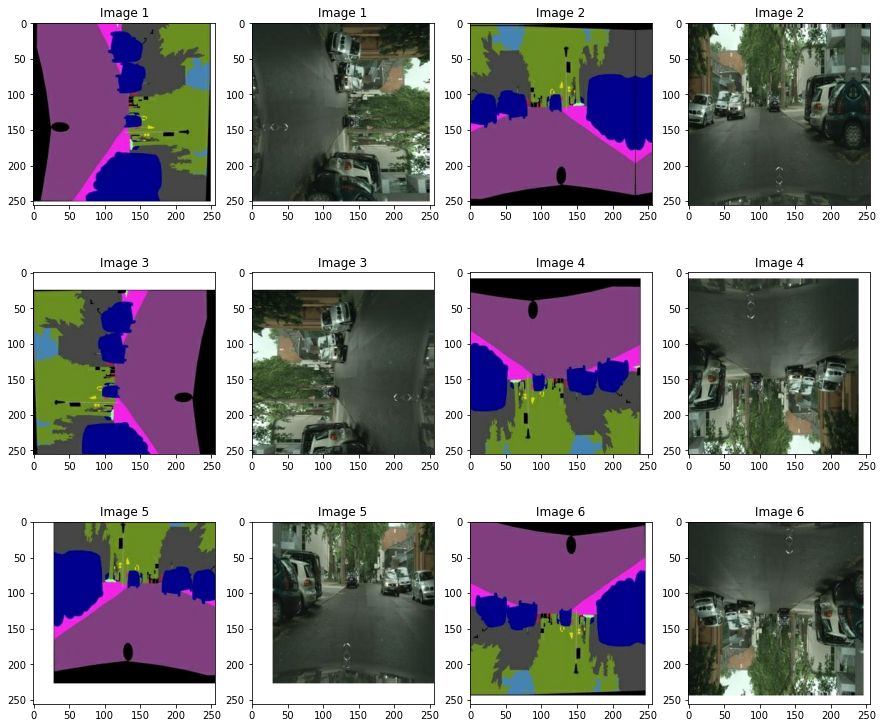

In [11]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

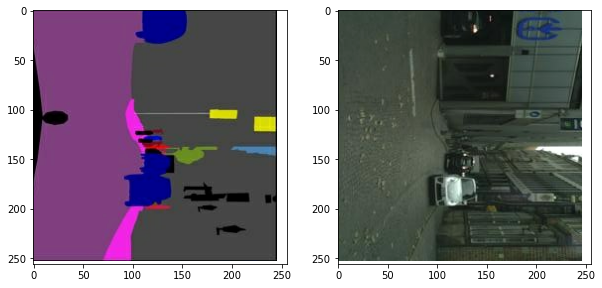

In [12]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [13]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [14]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [15]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [16]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [17]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [18]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [19]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [20]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [21]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

In [22]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [23]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [24]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [25]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

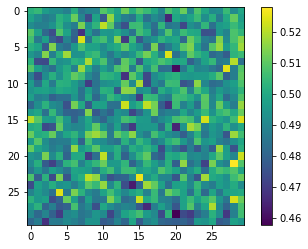

In [26]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [27]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [28]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [29]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [30]:
EPOCHS = 300

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8665                     
L1_loss:0.3132                     
Discriminator_loss:1.2922

EPOCH[1] - STEP[20]                     
Generator_loss:1.0021                     
L1_loss:0.2272                     
Discriminator_loss:1.1262

EPOCH[1] - STEP[30]                     
Generator_loss:1.0025                     
L1_loss:0.2172                     
Discriminator_loss:1.3000

EPOCH[1] - STEP[40]                     
Generator_loss:0.9674                     
L1_loss:0.2129                     
Discriminator_loss:1.2227

EPOCH[1] - STEP[50]                     
Generator_loss:0.7730                     
L1_loss:0.1807                     
Discriminator_loss:1.3633

EPOCH[1] - STEP[60]                     
Generator_loss:0.8556                     
L1_loss:0.1855                     
Discriminator_loss:1.1567

EPOCH[1] - STEP[70]                     
Generator_loss:1.0960                     
L1_loss:0.2074                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.3595                     
L1_loss:0.1882                     
Discriminator_loss:0.4074

EPOCH[3] - STEP[80]                     
Generator_loss:2.4825                     
L1_loss:0.2045                     
Discriminator_loss:0.4282

EPOCH[3] - STEP[90]                     
Generator_loss:1.8794                     
L1_loss:0.1939                     
Discriminator_loss:0.6777

EPOCH[3] - STEP[100]                     
Generator_loss:2.6551                     
L1_loss:0.1988                     
Discriminator_loss:0.8906

EPOCH[3] - STEP[110]                     
Generator_loss:0.6689                     
L1_loss:0.1898                     
Discriminator_loss:0.8988

EPOCH[3] - STEP[120]                     
Generator_loss:1.5189                     
L1_loss:0.1605                     
Discriminator_loss:1.0734

EPOCH[3] - STEP[130]                     
Generator_loss:1.0042                     
L1_loss:0.1913                

EPOCH[5] - STEP[130]                     
Generator_loss:1.0118                     
L1_loss:0.2003                     
Discriminator_loss:0.5821

EPOCH[5] - STEP[140]                     
Generator_loss:0.7311                     
L1_loss:0.2011                     
Discriminator_loss:0.7706

EPOCH[5] - STEP[150]                     
Generator_loss:1.5813                     
L1_loss:0.1943                     
Discriminator_loss:0.3542

EPOCH[5] - STEP[160]                     
Generator_loss:1.1066                     
L1_loss:0.1850                     
Discriminator_loss:1.3105

EPOCH[5] - STEP[170]                     
Generator_loss:1.2836                     
L1_loss:0.1848                     
Discriminator_loss:1.6986

EPOCH[5] - STEP[180]                     
Generator_loss:0.7965                     
L1_loss:0.1668                     
Discriminator_loss:0.9276

EPOCH[5] - STEP[190]                     
Generator_loss:1.4057                     
L1_loss:0.1731             

EPOCH[7] - STEP[190]                     
Generator_loss:2.1115                     
L1_loss:0.1864                     
Discriminator_loss:0.5516

EPOCH[7] - STEP[200]                     
Generator_loss:0.2121                     
L1_loss:0.2159                     
Discriminator_loss:1.8890

EPOCH[7] - STEP[210]                     
Generator_loss:1.7930                     
L1_loss:0.1620                     
Discriminator_loss:1.0688

EPOCH[7] - STEP[220]                     
Generator_loss:1.9610                     
L1_loss:0.1851                     
Discriminator_loss:0.5154

EPOCH[7] - STEP[230]                     
Generator_loss:1.6350                     
L1_loss:0.2164                     
Discriminator_loss:0.4384

EPOCH[7] - STEP[240]                     
Generator_loss:0.7882                     
L1_loss:0.1780                     
Discriminator_loss:0.7528

EPOCH[7] - STEP[250]                     
Generator_loss:0.4202                     
L1_loss:0.2002             

EPOCH[9] - STEP[250]                     
Generator_loss:0.4948                     
L1_loss:0.1747                     
Discriminator_loss:2.2116

EPOCH[10] - STEP[10]                     
Generator_loss:1.3570                     
L1_loss:0.1652                     
Discriminator_loss:0.9712

EPOCH[10] - STEP[20]                     
Generator_loss:2.4956                     
L1_loss:0.1677                     
Discriminator_loss:1.5848

EPOCH[10] - STEP[30]                     
Generator_loss:0.8780                     
L1_loss:0.1775                     
Discriminator_loss:0.9004

EPOCH[10] - STEP[40]                     
Generator_loss:2.1245                     
L1_loss:0.1592                     
Discriminator_loss:1.2234

EPOCH[10] - STEP[50]                     
Generator_loss:2.3557                     
L1_loss:0.1673                     
Discriminator_loss:1.2469

EPOCH[10] - STEP[60]                     
Generator_loss:1.8583                     
L1_loss:0.1922             

EPOCH[12] - STEP[60]                     
Generator_loss:2.3216                     
L1_loss:0.1806                     
Discriminator_loss:0.6594

EPOCH[12] - STEP[70]                     
Generator_loss:1.3806                     
L1_loss:0.1918                     
Discriminator_loss:1.0047

EPOCH[12] - STEP[80]                     
Generator_loss:1.7879                     
L1_loss:0.1664                     
Discriminator_loss:2.0098

EPOCH[12] - STEP[90]                     
Generator_loss:1.8442                     
L1_loss:0.1821                     
Discriminator_loss:0.3426

EPOCH[12] - STEP[100]                     
Generator_loss:1.3019                     
L1_loss:0.1648                     
Discriminator_loss:0.8154

EPOCH[12] - STEP[110]                     
Generator_loss:1.7242                     
L1_loss:0.1817                     
Discriminator_loss:0.3414

EPOCH[12] - STEP[120]                     
Generator_loss:1.1029                     
L1_loss:0.1812          

EPOCH[14] - STEP[120]                     
Generator_loss:1.8375                     
L1_loss:0.1634                     
Discriminator_loss:0.3825

EPOCH[14] - STEP[130]                     
Generator_loss:0.5769                     
L1_loss:0.1652                     
Discriminator_loss:1.1805

EPOCH[14] - STEP[140]                     
Generator_loss:0.8788                     
L1_loss:0.1684                     
Discriminator_loss:0.6470

EPOCH[14] - STEP[150]                     
Generator_loss:2.8073                     
L1_loss:0.1601                     
Discriminator_loss:0.8941

EPOCH[14] - STEP[160]                     
Generator_loss:1.9749                     
L1_loss:0.2314                     
Discriminator_loss:0.2730

EPOCH[14] - STEP[170]                     
Generator_loss:2.0573                     
L1_loss:0.1762                     
Discriminator_loss:1.0825

EPOCH[14] - STEP[180]                     
Generator_loss:1.1121                     
L1_loss:0.2050      

EPOCH[16] - STEP[180]                     
Generator_loss:2.4281                     
L1_loss:0.1773                     
Discriminator_loss:0.5914

EPOCH[16] - STEP[190]                     
Generator_loss:1.0017                     
L1_loss:0.1725                     
Discriminator_loss:0.7139

EPOCH[16] - STEP[200]                     
Generator_loss:2.6635                     
L1_loss:0.1884                     
Discriminator_loss:1.0368

EPOCH[16] - STEP[210]                     
Generator_loss:0.8561                     
L1_loss:0.1713                     
Discriminator_loss:0.7929

EPOCH[16] - STEP[220]                     
Generator_loss:1.8349                     
L1_loss:0.1972                     
Discriminator_loss:0.3604

EPOCH[16] - STEP[230]                     
Generator_loss:0.5883                     
L1_loss:0.1686                     
Discriminator_loss:1.1089

EPOCH[16] - STEP[240]                     
Generator_loss:0.8443                     
L1_loss:0.1815      

EPOCH[18] - STEP[240]                     
Generator_loss:0.9450                     
L1_loss:0.1741                     
Discriminator_loss:1.0775

EPOCH[18] - STEP[250]                     
Generator_loss:1.5100                     
L1_loss:0.1708                     
Discriminator_loss:0.7402

EPOCH[19] - STEP[10]                     
Generator_loss:1.1918                     
L1_loss:0.1528                     
Discriminator_loss:0.6510

EPOCH[19] - STEP[20]                     
Generator_loss:1.9365                     
L1_loss:0.1969                     
Discriminator_loss:0.4776

EPOCH[19] - STEP[30]                     
Generator_loss:1.8207                     
L1_loss:0.1533                     
Discriminator_loss:1.0651

EPOCH[19] - STEP[40]                     
Generator_loss:1.7105                     
L1_loss:0.1993                     
Discriminator_loss:0.2410

EPOCH[19] - STEP[50]                     
Generator_loss:0.5455                     
L1_loss:0.1880           

EPOCH[21] - STEP[50]                     
Generator_loss:1.6144                     
L1_loss:0.1929                     
Discriminator_loss:0.3659

EPOCH[21] - STEP[60]                     
Generator_loss:0.3865                     
L1_loss:0.1570                     
Discriminator_loss:1.3625

EPOCH[21] - STEP[70]                     
Generator_loss:1.3902                     
L1_loss:0.2080                     
Discriminator_loss:0.3862

EPOCH[21] - STEP[80]                     
Generator_loss:1.6562                     
L1_loss:0.1688                     
Discriminator_loss:0.5445

EPOCH[21] - STEP[90]                     
Generator_loss:1.8475                     
L1_loss:0.1801                     
Discriminator_loss:1.2487

EPOCH[21] - STEP[100]                     
Generator_loss:1.0363                     
L1_loss:0.1789                     
Discriminator_loss:0.5850

EPOCH[21] - STEP[110]                     
Generator_loss:0.7004                     
L1_loss:0.1683           

EPOCH[23] - STEP[110]                     
Generator_loss:0.5516                     
L1_loss:0.2138                     
Discriminator_loss:0.9987

EPOCH[23] - STEP[120]                     
Generator_loss:0.7478                     
L1_loss:0.1691                     
Discriminator_loss:0.9504

EPOCH[23] - STEP[130]                     
Generator_loss:0.9871                     
L1_loss:0.1890                     
Discriminator_loss:0.8897

EPOCH[23] - STEP[140]                     
Generator_loss:1.3340                     
L1_loss:0.1522                     
Discriminator_loss:0.5933

EPOCH[23] - STEP[150]                     
Generator_loss:1.8016                     
L1_loss:0.1688                     
Discriminator_loss:0.4135

EPOCH[23] - STEP[160]                     
Generator_loss:1.4655                     
L1_loss:0.2043                     
Discriminator_loss:0.3962

EPOCH[23] - STEP[170]                     
Generator_loss:1.7675                     
L1_loss:0.1779      

EPOCH[25] - STEP[170]                     
Generator_loss:1.9025                     
L1_loss:0.1408                     
Discriminator_loss:1.0247

EPOCH[25] - STEP[180]                     
Generator_loss:1.2807                     
L1_loss:0.2066                     
Discriminator_loss:0.4033

EPOCH[25] - STEP[190]                     
Generator_loss:1.3378                     
L1_loss:0.1601                     
Discriminator_loss:1.3505

EPOCH[25] - STEP[200]                     
Generator_loss:1.7176                     
L1_loss:0.1737                     
Discriminator_loss:1.3125

EPOCH[25] - STEP[210]                     
Generator_loss:0.6239                     
L1_loss:0.1737                     
Discriminator_loss:1.1697

EPOCH[25] - STEP[220]                     
Generator_loss:0.9790                     
L1_loss:0.1841                     
Discriminator_loss:1.0944

EPOCH[25] - STEP[230]                     
Generator_loss:1.6163                     
L1_loss:0.1895      

EPOCH[27] - STEP[230]                     
Generator_loss:2.3127                     
L1_loss:0.2040                     
Discriminator_loss:0.2418

EPOCH[27] - STEP[240]                     
Generator_loss:1.4224                     
L1_loss:0.2224                     
Discriminator_loss:0.3911

EPOCH[27] - STEP[250]                     
Generator_loss:1.1120                     
L1_loss:0.1801                     
Discriminator_loss:0.6423

EPOCH[28] - STEP[10]                     
Generator_loss:0.9583                     
L1_loss:0.1959                     
Discriminator_loss:0.5662

EPOCH[28] - STEP[20]                     
Generator_loss:0.4861                     
L1_loss:0.1844                     
Discriminator_loss:1.3384

EPOCH[28] - STEP[30]                     
Generator_loss:1.3222                     
L1_loss:0.2263                     
Discriminator_loss:0.9891

EPOCH[28] - STEP[40]                     
Generator_loss:2.2594                     
L1_loss:0.1736          

EPOCH[30] - STEP[40]                     
Generator_loss:1.4595                     
L1_loss:0.2006                     
Discriminator_loss:0.3472

EPOCH[30] - STEP[50]                     
Generator_loss:1.5604                     
L1_loss:0.1922                     
Discriminator_loss:0.9272

EPOCH[30] - STEP[60]                     
Generator_loss:2.7120                     
L1_loss:0.1874                     
Discriminator_loss:0.1503

EPOCH[30] - STEP[70]                     
Generator_loss:1.8715                     
L1_loss:0.1950                     
Discriminator_loss:0.8210

EPOCH[30] - STEP[80]                     
Generator_loss:2.0090                     
L1_loss:0.1720                     
Discriminator_loss:0.7047

EPOCH[30] - STEP[90]                     
Generator_loss:1.1465                     
L1_loss:0.1905                     
Discriminator_loss:0.8197

EPOCH[30] - STEP[100]                     
Generator_loss:1.1577                     
L1_loss:0.2405            

EPOCH[32] - STEP[100]                     
Generator_loss:1.6890                     
L1_loss:0.1812                     
Discriminator_loss:0.6561

EPOCH[32] - STEP[110]                     
Generator_loss:1.6335                     
L1_loss:0.1711                     
Discriminator_loss:0.8286

EPOCH[32] - STEP[120]                     
Generator_loss:2.1060                     
L1_loss:0.1713                     
Discriminator_loss:0.4400

EPOCH[32] - STEP[130]                     
Generator_loss:1.2068                     
L1_loss:0.1615                     
Discriminator_loss:1.0082

EPOCH[32] - STEP[140]                     
Generator_loss:2.3693                     
L1_loss:0.1528                     
Discriminator_loss:0.6602

EPOCH[32] - STEP[150]                     
Generator_loss:2.8508                     
L1_loss:0.1839                     
Discriminator_loss:0.7942

EPOCH[32] - STEP[160]                     
Generator_loss:0.1511                     
L1_loss:0.1890      

EPOCH[34] - STEP[160]                     
Generator_loss:1.8601                     
L1_loss:0.2031                     
Discriminator_loss:0.2805

EPOCH[34] - STEP[170]                     
Generator_loss:1.3430                     
L1_loss:0.1626                     
Discriminator_loss:0.5124

EPOCH[34] - STEP[180]                     
Generator_loss:1.8036                     
L1_loss:0.1491                     
Discriminator_loss:1.1383

EPOCH[34] - STEP[190]                     
Generator_loss:1.1240                     
L1_loss:0.1664                     
Discriminator_loss:0.6635

EPOCH[34] - STEP[200]                     
Generator_loss:1.5502                     
L1_loss:0.1685                     
Discriminator_loss:2.4785

EPOCH[34] - STEP[210]                     
Generator_loss:1.5532                     
L1_loss:0.1484                     
Discriminator_loss:0.7222

EPOCH[34] - STEP[220]                     
Generator_loss:1.9096                     
L1_loss:0.1573      

EPOCH[36] - STEP[220]                     
Generator_loss:0.4002                     
L1_loss:0.1822                     
Discriminator_loss:1.2871

EPOCH[36] - STEP[230]                     
Generator_loss:1.6024                     
L1_loss:0.1687                     
Discriminator_loss:0.4247

EPOCH[36] - STEP[240]                     
Generator_loss:1.7669                     
L1_loss:0.1604                     
Discriminator_loss:2.2092

EPOCH[36] - STEP[250]                     
Generator_loss:0.9302                     
L1_loss:0.1550                     
Discriminator_loss:1.0716

EPOCH[37] - STEP[10]                     
Generator_loss:1.9841                     
L1_loss:0.1590                     
Discriminator_loss:2.3224

EPOCH[37] - STEP[20]                     
Generator_loss:2.4374                     
L1_loss:0.1394                     
Discriminator_loss:1.6898

EPOCH[37] - STEP[30]                     
Generator_loss:1.0239                     
L1_loss:0.1721         

EPOCH[39] - STEP[30]                     
Generator_loss:0.7073                     
L1_loss:0.1963                     
Discriminator_loss:0.9529

EPOCH[39] - STEP[40]                     
Generator_loss:1.1505                     
L1_loss:0.1599                     
Discriminator_loss:1.3031

EPOCH[39] - STEP[50]                     
Generator_loss:1.2842                     
L1_loss:0.1691                     
Discriminator_loss:0.7960

EPOCH[39] - STEP[60]                     
Generator_loss:1.3485                     
L1_loss:0.1601                     
Discriminator_loss:1.1817

EPOCH[39] - STEP[70]                     
Generator_loss:2.0435                     
L1_loss:0.1298                     
Discriminator_loss:1.9348

EPOCH[39] - STEP[80]                     
Generator_loss:1.8549                     
L1_loss:0.1652                     
Discriminator_loss:0.6400

EPOCH[39] - STEP[90]                     
Generator_loss:1.5406                     
L1_loss:0.1541             

EPOCH[41] - STEP[90]                     
Generator_loss:1.2484                     
L1_loss:0.2161                     
Discriminator_loss:0.4047

EPOCH[41] - STEP[100]                     
Generator_loss:2.0484                     
L1_loss:0.1699                     
Discriminator_loss:0.9672

EPOCH[41] - STEP[110]                     
Generator_loss:1.2290                     
L1_loss:0.1986                     
Discriminator_loss:0.4395

EPOCH[41] - STEP[120]                     
Generator_loss:1.4365                     
L1_loss:0.1988                     
Discriminator_loss:0.3834

EPOCH[41] - STEP[130]                     
Generator_loss:2.1465                     
L1_loss:0.2051                     
Discriminator_loss:0.4862

EPOCH[41] - STEP[140]                     
Generator_loss:1.5837                     
L1_loss:0.1557                     
Discriminator_loss:0.8868

EPOCH[41] - STEP[150]                     
Generator_loss:1.8219                     
L1_loss:0.1759       

EPOCH[43] - STEP[150]                     
Generator_loss:2.0079                     
L1_loss:0.1565                     
Discriminator_loss:0.6901

EPOCH[43] - STEP[160]                     
Generator_loss:1.4163                     
L1_loss:0.1906                     
Discriminator_loss:0.5174

EPOCH[43] - STEP[170]                     
Generator_loss:1.2294                     
L1_loss:0.1901                     
Discriminator_loss:0.4535

EPOCH[43] - STEP[180]                     
Generator_loss:2.0649                     
L1_loss:0.1652                     
Discriminator_loss:0.7767

EPOCH[43] - STEP[190]                     
Generator_loss:0.4148                     
L1_loss:0.1616                     
Discriminator_loss:1.4833

EPOCH[43] - STEP[200]                     
Generator_loss:1.4489                     
L1_loss:0.2008                     
Discriminator_loss:0.3730

EPOCH[43] - STEP[210]                     
Generator_loss:0.2977                     
L1_loss:0.1881      

EPOCH[45] - STEP[210]                     
Generator_loss:1.2699                     
L1_loss:0.1497                     
Discriminator_loss:1.4288

EPOCH[45] - STEP[220]                     
Generator_loss:0.7920                     
L1_loss:0.1887                     
Discriminator_loss:0.7614

EPOCH[45] - STEP[230]                     
Generator_loss:1.2364                     
L1_loss:0.1684                     
Discriminator_loss:1.8224

EPOCH[45] - STEP[240]                     
Generator_loss:1.3449                     
L1_loss:0.1560                     
Discriminator_loss:1.1213

EPOCH[45] - STEP[250]                     
Generator_loss:2.3955                     
L1_loss:0.1838                     
Discriminator_loss:0.9442

EPOCH[46] - STEP[10]                     
Generator_loss:1.2805                     
L1_loss:0.1581                     
Discriminator_loss:1.0823

EPOCH[46] - STEP[20]                     
Generator_loss:0.6408                     
L1_loss:0.1582        

EPOCH[48] - STEP[20]                     
Generator_loss:0.7393                     
L1_loss:0.1988                     
Discriminator_loss:0.7468

EPOCH[48] - STEP[30]                     
Generator_loss:0.7905                     
L1_loss:0.1701                     
Discriminator_loss:1.0897

EPOCH[48] - STEP[40]                     
Generator_loss:0.8696                     
L1_loss:0.1850                     
Discriminator_loss:0.8250

EPOCH[48] - STEP[50]                     
Generator_loss:0.6409                     
L1_loss:0.1525                     
Discriminator_loss:1.4573

EPOCH[48] - STEP[60]                     
Generator_loss:1.8953                     
L1_loss:0.1735                     
Discriminator_loss:0.9757

EPOCH[48] - STEP[70]                     
Generator_loss:0.5103                     
L1_loss:0.1701                     
Discriminator_loss:1.1362

EPOCH[48] - STEP[80]                     
Generator_loss:1.8142                     
L1_loss:0.1595             

EPOCH[50] - STEP[80]                     
Generator_loss:0.3412                     
L1_loss:0.1679                     
Discriminator_loss:1.9975

EPOCH[50] - STEP[90]                     
Generator_loss:0.9360                     
L1_loss:0.1501                     
Discriminator_loss:0.7382

EPOCH[50] - STEP[100]                     
Generator_loss:0.9870                     
L1_loss:0.1717                     
Discriminator_loss:1.6421

EPOCH[50] - STEP[110]                     
Generator_loss:1.9326                     
L1_loss:0.1550                     
Discriminator_loss:1.5309

EPOCH[50] - STEP[120]                     
Generator_loss:1.4370                     
L1_loss:0.1598                     
Discriminator_loss:1.0307

EPOCH[50] - STEP[130]                     
Generator_loss:1.3436                     
L1_loss:0.2345                     
Discriminator_loss:0.3701

EPOCH[50] - STEP[140]                     
Generator_loss:2.3200                     
L1_loss:0.1597        

EPOCH[52] - STEP[140]                     
Generator_loss:0.3657                     
L1_loss:0.1450                     
Discriminator_loss:1.6389

EPOCH[52] - STEP[150]                     
Generator_loss:1.6802                     
L1_loss:0.1849                     
Discriminator_loss:0.3880

EPOCH[52] - STEP[160]                     
Generator_loss:1.7879                     
L1_loss:0.1730                     
Discriminator_loss:1.2647

EPOCH[52] - STEP[170]                     
Generator_loss:1.2155                     
L1_loss:0.1485                     
Discriminator_loss:0.7579

EPOCH[52] - STEP[180]                     
Generator_loss:1.8453                     
L1_loss:0.1795                     
Discriminator_loss:0.5844

EPOCH[52] - STEP[190]                     
Generator_loss:2.3793                     
L1_loss:0.1888                     
Discriminator_loss:0.9690

EPOCH[52] - STEP[200]                     
Generator_loss:1.0000                     
L1_loss:0.1708      

EPOCH[54] - STEP[200]                     
Generator_loss:1.1894                     
L1_loss:0.1805                     
Discriminator_loss:0.6339

EPOCH[54] - STEP[210]                     
Generator_loss:1.0892                     
L1_loss:0.1592                     
Discriminator_loss:1.1063

EPOCH[54] - STEP[220]                     
Generator_loss:2.8254                     
L1_loss:0.1687                     
Discriminator_loss:1.8388

EPOCH[54] - STEP[230]                     
Generator_loss:0.9946                     
L1_loss:0.1648                     
Discriminator_loss:0.9371

EPOCH[54] - STEP[240]                     
Generator_loss:0.6405                     
L1_loss:0.1874                     
Discriminator_loss:0.9588

EPOCH[54] - STEP[250]                     
Generator_loss:1.2350                     
L1_loss:0.1411                     
Discriminator_loss:1.6850

EPOCH[55] - STEP[10]                     
Generator_loss:1.8111                     
L1_loss:0.1907       

EPOCH[57] - STEP[10]                     
Generator_loss:0.7310                     
L1_loss:0.1774                     
Discriminator_loss:0.9759

EPOCH[57] - STEP[20]                     
Generator_loss:0.1987                     
L1_loss:0.1977                     
Discriminator_loss:1.9402

EPOCH[57] - STEP[30]                     
Generator_loss:0.3177                     
L1_loss:0.1591                     
Discriminator_loss:1.6113

EPOCH[57] - STEP[40]                     
Generator_loss:2.3000                     
L1_loss:0.1492                     
Discriminator_loss:1.3572

EPOCH[57] - STEP[50]                     
Generator_loss:1.8314                     
L1_loss:0.1664                     
Discriminator_loss:2.1191

EPOCH[57] - STEP[60]                     
Generator_loss:2.1091                     
L1_loss:0.1886                     
Discriminator_loss:0.4418

EPOCH[57] - STEP[70]                     
Generator_loss:1.7671                     
L1_loss:0.2025             

EPOCH[59] - STEP[70]                     
Generator_loss:0.7003                     
L1_loss:0.1826                     
Discriminator_loss:0.8318

EPOCH[59] - STEP[80]                     
Generator_loss:1.3285                     
L1_loss:0.1642                     
Discriminator_loss:0.7809

EPOCH[59] - STEP[90]                     
Generator_loss:1.0026                     
L1_loss:0.1569                     
Discriminator_loss:1.0905

EPOCH[59] - STEP[100]                     
Generator_loss:0.7531                     
L1_loss:0.1414                     
Discriminator_loss:1.6984

EPOCH[59] - STEP[110]                     
Generator_loss:1.0710                     
L1_loss:0.1893                     
Discriminator_loss:0.6375

EPOCH[59] - STEP[120]                     
Generator_loss:2.0229                     
L1_loss:0.2017                     
Discriminator_loss:0.7600

EPOCH[59] - STEP[130]                     
Generator_loss:0.5736                     
L1_loss:0.1834         

EPOCH[61] - STEP[130]                     
Generator_loss:1.5371                     
L1_loss:0.1623                     
Discriminator_loss:0.4619

EPOCH[61] - STEP[140]                     
Generator_loss:1.9380                     
L1_loss:0.1519                     
Discriminator_loss:1.7070

EPOCH[61] - STEP[150]                     
Generator_loss:1.8295                     
L1_loss:0.1374                     
Discriminator_loss:2.1677

EPOCH[61] - STEP[160]                     
Generator_loss:1.1485                     
L1_loss:0.1903                     
Discriminator_loss:0.9241

EPOCH[61] - STEP[170]                     
Generator_loss:1.8231                     
L1_loss:0.1721                     
Discriminator_loss:0.5872

EPOCH[61] - STEP[180]                     
Generator_loss:1.2024                     
L1_loss:0.1940                     
Discriminator_loss:0.6451

EPOCH[61] - STEP[190]                     
Generator_loss:2.2683                     
L1_loss:0.1573      

EPOCH[63] - STEP[190]                     
Generator_loss:1.6197                     
L1_loss:0.2007                     
Discriminator_loss:1.2603

EPOCH[63] - STEP[200]                     
Generator_loss:0.7286                     
L1_loss:0.1666                     
Discriminator_loss:1.1869

EPOCH[63] - STEP[210]                     
Generator_loss:0.9949                     
L1_loss:0.1550                     
Discriminator_loss:1.0329

EPOCH[63] - STEP[220]                     
Generator_loss:1.6384                     
L1_loss:0.1791                     
Discriminator_loss:0.5300

EPOCH[63] - STEP[230]                     
Generator_loss:1.5984                     
L1_loss:0.1663                     
Discriminator_loss:0.9594

EPOCH[63] - STEP[240]                     
Generator_loss:1.6739                     
L1_loss:0.1866                     
Discriminator_loss:0.9470

EPOCH[63] - STEP[250]                     
Generator_loss:1.8466                     
L1_loss:0.1634      

EPOCH[65] - STEP[250]                     
Generator_loss:1.4484                     
L1_loss:0.1584                     
Discriminator_loss:1.1584

EPOCH[66] - STEP[10]                     
Generator_loss:1.1070                     
L1_loss:0.1936                     
Discriminator_loss:0.5043

EPOCH[66] - STEP[20]                     
Generator_loss:0.9930                     
L1_loss:0.1771                     
Discriminator_loss:0.9097

EPOCH[66] - STEP[30]                     
Generator_loss:0.9226                     
L1_loss:0.1448                     
Discriminator_loss:1.2213

EPOCH[66] - STEP[40]                     
Generator_loss:1.7735                     
L1_loss:0.1589                     
Discriminator_loss:0.4138

EPOCH[66] - STEP[50]                     
Generator_loss:0.9262                     
L1_loss:0.1932                     
Discriminator_loss:0.6031

EPOCH[66] - STEP[60]                     
Generator_loss:1.7704                     
L1_loss:0.1535            

EPOCH[68] - STEP[60]                     
Generator_loss:1.4672                     
L1_loss:0.1851                     
Discriminator_loss:0.6120

EPOCH[68] - STEP[70]                     
Generator_loss:1.6681                     
L1_loss:0.1723                     
Discriminator_loss:0.6495

EPOCH[68] - STEP[80]                     
Generator_loss:2.8965                     
L1_loss:0.1779                     
Discriminator_loss:0.4101

EPOCH[68] - STEP[90]                     
Generator_loss:1.6516                     
L1_loss:0.1560                     
Discriminator_loss:0.4828

EPOCH[68] - STEP[100]                     
Generator_loss:0.9983                     
L1_loss:0.1556                     
Discriminator_loss:0.9040

EPOCH[68] - STEP[110]                     
Generator_loss:1.6083                     
L1_loss:0.1633                     
Discriminator_loss:1.8392

EPOCH[68] - STEP[120]                     
Generator_loss:1.6777                     
L1_loss:0.1541          

EPOCH[70] - STEP[120]                     
Generator_loss:1.5443                     
L1_loss:0.1603                     
Discriminator_loss:0.6122

EPOCH[70] - STEP[130]                     
Generator_loss:1.3000                     
L1_loss:0.1733                     
Discriminator_loss:0.6865

EPOCH[70] - STEP[140]                     
Generator_loss:0.8068                     
L1_loss:0.1674                     
Discriminator_loss:1.9832

EPOCH[70] - STEP[150]                     
Generator_loss:2.1147                     
L1_loss:0.1704                     
Discriminator_loss:0.9319

EPOCH[70] - STEP[160]                     
Generator_loss:2.3398                     
L1_loss:0.1697                     
Discriminator_loss:0.7680

EPOCH[70] - STEP[170]                     
Generator_loss:1.5284                     
L1_loss:0.1820                     
Discriminator_loss:0.5205

EPOCH[70] - STEP[180]                     
Generator_loss:1.7530                     
L1_loss:0.1588      

EPOCH[72] - STEP[180]                     
Generator_loss:1.2114                     
L1_loss:0.1585                     
Discriminator_loss:1.3851

EPOCH[72] - STEP[190]                     
Generator_loss:0.7496                     
L1_loss:0.1827                     
Discriminator_loss:0.8391

EPOCH[72] - STEP[200]                     
Generator_loss:1.9087                     
L1_loss:0.1358                     
Discriminator_loss:0.8927

EPOCH[72] - STEP[210]                     
Generator_loss:1.6136                     
L1_loss:0.1608                     
Discriminator_loss:1.4864

EPOCH[72] - STEP[220]                     
Generator_loss:2.0328                     
L1_loss:0.1896                     
Discriminator_loss:0.3379

EPOCH[72] - STEP[230]                     
Generator_loss:1.9238                     
L1_loss:0.1620                     
Discriminator_loss:0.9890

EPOCH[72] - STEP[240]                     
Generator_loss:0.8601                     
L1_loss:0.1600      

EPOCH[74] - STEP[240]                     
Generator_loss:2.5081                     
L1_loss:0.1963                     
Discriminator_loss:0.1430

EPOCH[74] - STEP[250]                     
Generator_loss:2.0563                     
L1_loss:0.1900                     
Discriminator_loss:1.0991

EPOCH[75] - STEP[10]                     
Generator_loss:1.2497                     
L1_loss:0.2116                     
Discriminator_loss:0.4086

EPOCH[75] - STEP[20]                     
Generator_loss:1.1705                     
L1_loss:0.1652                     
Discriminator_loss:0.6854

EPOCH[75] - STEP[30]                     
Generator_loss:1.6281                     
L1_loss:0.1918                     
Discriminator_loss:0.2923

EPOCH[75] - STEP[40]                     
Generator_loss:1.1109                     
L1_loss:0.1714                     
Discriminator_loss:0.4803

EPOCH[75] - STEP[50]                     
Generator_loss:0.6222                     
L1_loss:0.1886           

EPOCH[77] - STEP[50]                     
Generator_loss:0.9867                     
L1_loss:0.1538                     
Discriminator_loss:2.2928

EPOCH[77] - STEP[60]                     
Generator_loss:1.2998                     
L1_loss:0.1543                     
Discriminator_loss:0.9131

EPOCH[77] - STEP[70]                     
Generator_loss:1.7942                     
L1_loss:0.1723                     
Discriminator_loss:0.7741

EPOCH[77] - STEP[80]                     
Generator_loss:1.0879                     
L1_loss:0.2049                     
Discriminator_loss:0.5097

EPOCH[77] - STEP[90]                     
Generator_loss:1.4441                     
L1_loss:0.1612                     
Discriminator_loss:1.0661

EPOCH[77] - STEP[100]                     
Generator_loss:0.8513                     
L1_loss:0.1934                     
Discriminator_loss:0.7692

EPOCH[77] - STEP[110]                     
Generator_loss:1.4366                     
L1_loss:0.1624           

EPOCH[79] - STEP[110]                     
Generator_loss:1.1368                     
L1_loss:0.1730                     
Discriminator_loss:1.5736

EPOCH[79] - STEP[120]                     
Generator_loss:0.8678                     
L1_loss:0.1861                     
Discriminator_loss:0.7004

EPOCH[79] - STEP[130]                     
Generator_loss:1.0915                     
L1_loss:0.1770                     
Discriminator_loss:0.6392

EPOCH[79] - STEP[140]                     
Generator_loss:0.7148                     
L1_loss:0.1739                     
Discriminator_loss:0.8508

EPOCH[79] - STEP[150]                     
Generator_loss:1.3212                     
L1_loss:0.1887                     
Discriminator_loss:0.4718

EPOCH[79] - STEP[160]                     
Generator_loss:2.2977                     
L1_loss:0.1632                     
Discriminator_loss:0.2767

EPOCH[79] - STEP[170]                     
Generator_loss:1.5102                     
L1_loss:0.1984      

EPOCH[81] - STEP[170]                     
Generator_loss:0.6372                     
L1_loss:0.1726                     
Discriminator_loss:1.0333

EPOCH[81] - STEP[180]                     
Generator_loss:1.7833                     
L1_loss:0.2029                     
Discriminator_loss:0.6226

EPOCH[81] - STEP[190]                     
Generator_loss:1.1294                     
L1_loss:0.1801                     
Discriminator_loss:0.7489

EPOCH[81] - STEP[200]                     
Generator_loss:1.5403                     
L1_loss:0.1663                     
Discriminator_loss:1.9040

EPOCH[81] - STEP[210]                     
Generator_loss:1.7949                     
L1_loss:0.1414                     
Discriminator_loss:0.8233

EPOCH[81] - STEP[220]                     
Generator_loss:2.6454                     
L1_loss:0.1849                     
Discriminator_loss:0.1463

EPOCH[81] - STEP[230]                     
Generator_loss:0.7524                     
L1_loss:0.1992      

EPOCH[83] - STEP[230]                     
Generator_loss:0.9572                     
L1_loss:0.1812                     
Discriminator_loss:1.8689

EPOCH[83] - STEP[240]                     
Generator_loss:1.7654                     
L1_loss:0.1647                     
Discriminator_loss:2.4846

EPOCH[83] - STEP[250]                     
Generator_loss:1.9677                     
L1_loss:0.1719                     
Discriminator_loss:0.4257

EPOCH[84] - STEP[10]                     
Generator_loss:1.1416                     
L1_loss:0.1562                     
Discriminator_loss:0.8826

EPOCH[84] - STEP[20]                     
Generator_loss:1.7765                     
L1_loss:0.2424                     
Discriminator_loss:0.2486

EPOCH[84] - STEP[30]                     
Generator_loss:1.0587                     
L1_loss:0.1885                     
Discriminator_loss:0.6773

EPOCH[84] - STEP[40]                     
Generator_loss:2.3032                     
L1_loss:0.1555          

EPOCH[86] - STEP[40]                     
Generator_loss:1.1533                     
L1_loss:0.1575                     
Discriminator_loss:1.0884

EPOCH[86] - STEP[50]                     
Generator_loss:2.0340                     
L1_loss:0.1716                     
Discriminator_loss:0.5095

EPOCH[86] - STEP[60]                     
Generator_loss:0.5629                     
L1_loss:0.1468                     
Discriminator_loss:1.3833

EPOCH[86] - STEP[70]                     
Generator_loss:1.0189                     
L1_loss:0.2012                     
Discriminator_loss:0.5225

EPOCH[86] - STEP[80]                     
Generator_loss:2.0506                     
L1_loss:0.1873                     
Discriminator_loss:0.3660

EPOCH[86] - STEP[90]                     
Generator_loss:2.4802                     
L1_loss:0.1529                     
Discriminator_loss:1.9157

EPOCH[86] - STEP[100]                     
Generator_loss:1.4897                     
L1_loss:0.1530            

EPOCH[88] - STEP[100]                     
Generator_loss:2.0925                     
L1_loss:0.1534                     
Discriminator_loss:1.8862

EPOCH[88] - STEP[110]                     
Generator_loss:1.7155                     
L1_loss:0.1494                     
Discriminator_loss:0.8865

EPOCH[88] - STEP[120]                     
Generator_loss:1.2119                     
L1_loss:0.1440                     
Discriminator_loss:0.7683

EPOCH[88] - STEP[130]                     
Generator_loss:1.9868                     
L1_loss:0.1789                     
Discriminator_loss:1.3435

EPOCH[88] - STEP[140]                     
Generator_loss:2.0521                     
L1_loss:0.1945                     
Discriminator_loss:0.3696

EPOCH[88] - STEP[150]                     
Generator_loss:1.8245                     
L1_loss:0.1938                     
Discriminator_loss:0.2250

EPOCH[88] - STEP[160]                     
Generator_loss:0.4658                     
L1_loss:0.1698      

EPOCH[90] - STEP[160]                     
Generator_loss:1.5153                     
L1_loss:0.1577                     
Discriminator_loss:1.9493

EPOCH[90] - STEP[170]                     
Generator_loss:1.8526                     
L1_loss:0.1771                     
Discriminator_loss:0.3874

EPOCH[90] - STEP[180]                     
Generator_loss:1.3800                     
L1_loss:0.1617                     
Discriminator_loss:1.0323

EPOCH[90] - STEP[190]                     
Generator_loss:1.6231                     
L1_loss:0.1638                     
Discriminator_loss:1.3447

EPOCH[90] - STEP[200]                     
Generator_loss:1.4250                     
L1_loss:0.1892                     
Discriminator_loss:0.4180

EPOCH[90] - STEP[210]                     
Generator_loss:0.7709                     
L1_loss:0.1811                     
Discriminator_loss:0.7419

EPOCH[90] - STEP[220]                     
Generator_loss:1.7595                     
L1_loss:0.1715      

EPOCH[92] - STEP[220]                     
Generator_loss:0.5905                     
L1_loss:0.1793                     
Discriminator_loss:1.1780

EPOCH[92] - STEP[230]                     
Generator_loss:0.4118                     
L1_loss:0.2030                     
Discriminator_loss:1.5493

EPOCH[92] - STEP[240]                     
Generator_loss:1.3052                     
L1_loss:0.1491                     
Discriminator_loss:0.9258

EPOCH[92] - STEP[250]                     
Generator_loss:2.3850                     
L1_loss:0.1688                     
Discriminator_loss:0.2474

EPOCH[93] - STEP[10]                     
Generator_loss:0.8828                     
L1_loss:0.1895                     
Discriminator_loss:1.0774

EPOCH[93] - STEP[20]                     
Generator_loss:0.6500                     
L1_loss:0.1444                     
Discriminator_loss:0.9947

EPOCH[93] - STEP[30]                     
Generator_loss:1.4889                     
L1_loss:0.2177         

EPOCH[95] - STEP[30]                     
Generator_loss:0.5939                     
L1_loss:0.1751                     
Discriminator_loss:1.0246

EPOCH[95] - STEP[40]                     
Generator_loss:0.9776                     
L1_loss:0.1546                     
Discriminator_loss:1.0445

EPOCH[95] - STEP[50]                     
Generator_loss:1.4922                     
L1_loss:0.1747                     
Discriminator_loss:0.3051

EPOCH[95] - STEP[60]                     
Generator_loss:2.4297                     
L1_loss:0.1757                     
Discriminator_loss:1.2715

EPOCH[95] - STEP[70]                     
Generator_loss:1.8513                     
L1_loss:0.1652                     
Discriminator_loss:1.2047

EPOCH[95] - STEP[80]                     
Generator_loss:1.1852                     
L1_loss:0.1569                     
Discriminator_loss:0.6618

EPOCH[95] - STEP[90]                     
Generator_loss:1.9457                     
L1_loss:0.2013             

EPOCH[97] - STEP[90]                     
Generator_loss:1.6977                     
L1_loss:0.1679                     
Discriminator_loss:0.7991

EPOCH[97] - STEP[100]                     
Generator_loss:1.8862                     
L1_loss:0.1767                     
Discriminator_loss:0.2756

EPOCH[97] - STEP[110]                     
Generator_loss:0.9629                     
L1_loss:0.1444                     
Discriminator_loss:1.1134

EPOCH[97] - STEP[120]                     
Generator_loss:1.9046                     
L1_loss:0.1886                     
Discriminator_loss:0.2128

EPOCH[97] - STEP[130]                     
Generator_loss:1.9678                     
L1_loss:0.1906                     
Discriminator_loss:1.1967

EPOCH[97] - STEP[140]                     
Generator_loss:1.1906                     
L1_loss:0.1733                     
Discriminator_loss:1.0914

EPOCH[97] - STEP[150]                     
Generator_loss:0.8002                     
L1_loss:0.1769       

EPOCH[99] - STEP[150]                     
Generator_loss:1.7401                     
L1_loss:0.2465                     
Discriminator_loss:0.2513

EPOCH[99] - STEP[160]                     
Generator_loss:0.7993                     
L1_loss:0.1736                     
Discriminator_loss:1.1041

EPOCH[99] - STEP[170]                     
Generator_loss:1.0941                     
L1_loss:0.1543                     
Discriminator_loss:1.5398

EPOCH[99] - STEP[180]                     
Generator_loss:2.1027                     
L1_loss:0.1393                     
Discriminator_loss:1.5866

EPOCH[99] - STEP[190]                     
Generator_loss:1.4337                     
L1_loss:0.1749                     
Discriminator_loss:0.4768

EPOCH[99] - STEP[200]                     
Generator_loss:1.6105                     
L1_loss:0.1661                     
Discriminator_loss:0.3820

EPOCH[99] - STEP[210]                     
Generator_loss:1.6689                     
L1_loss:0.1706      

EPOCH[101] - STEP[200]                     
Generator_loss:1.0293                     
L1_loss:0.1510                     
Discriminator_loss:1.3886

EPOCH[101] - STEP[210]                     
Generator_loss:0.3367                     
L1_loss:0.2119                     
Discriminator_loss:1.5563

EPOCH[101] - STEP[220]                     
Generator_loss:1.7871                     
L1_loss:0.1690                     
Discriminator_loss:1.7166

EPOCH[101] - STEP[230]                     
Generator_loss:1.0417                     
L1_loss:0.1601                     
Discriminator_loss:1.4039

EPOCH[101] - STEP[240]                     
Generator_loss:1.2738                     
L1_loss:0.1728                     
Discriminator_loss:0.4618

EPOCH[101] - STEP[250]                     
Generator_loss:1.3392                     
L1_loss:0.1552                     
Discriminator_loss:2.5605

EPOCH[102] - STEP[10]                     
Generator_loss:1.5930                     
L1_loss:0.1500

EPOCH[103] - STEP[250]                     
Generator_loss:1.9297                     
L1_loss:0.1711                     
Discriminator_loss:0.4922

EPOCH[104] - STEP[10]                     
Generator_loss:1.0503                     
L1_loss:0.1546                     
Discriminator_loss:2.1915

EPOCH[104] - STEP[20]                     
Generator_loss:2.1955                     
L1_loss:0.1610                     
Discriminator_loss:1.8313

EPOCH[104] - STEP[30]                     
Generator_loss:1.3425                     
L1_loss:0.1608                     
Discriminator_loss:0.4699

EPOCH[104] - STEP[40]                     
Generator_loss:2.3501                     
L1_loss:0.1351                     
Discriminator_loss:2.3268

EPOCH[104] - STEP[50]                     
Generator_loss:1.0688                     
L1_loss:0.1859                     
Discriminator_loss:0.7156

EPOCH[104] - STEP[60]                     
Generator_loss:0.4608                     
L1_loss:0.1805     

EPOCH[106] - STEP[50]                     
Generator_loss:1.1304                     
L1_loss:0.1738                     
Discriminator_loss:0.5431

EPOCH[106] - STEP[60]                     
Generator_loss:1.6737                     
L1_loss:0.1753                     
Discriminator_loss:0.7234

EPOCH[106] - STEP[70]                     
Generator_loss:2.1876                     
L1_loss:0.1794                     
Discriminator_loss:0.2009

EPOCH[106] - STEP[80]                     
Generator_loss:1.2904                     
L1_loss:0.1995                     
Discriminator_loss:0.4217

EPOCH[106] - STEP[90]                     
Generator_loss:1.6396                     
L1_loss:0.1576                     
Discriminator_loss:0.9370

EPOCH[106] - STEP[100]                     
Generator_loss:1.0735                     
L1_loss:0.2069                     
Discriminator_loss:0.5063

EPOCH[106] - STEP[110]                     
Generator_loss:1.7180                     
L1_loss:0.1726    

EPOCH[108] - STEP[100]                     
Generator_loss:1.8353                     
L1_loss:0.1601                     
Discriminator_loss:0.3734

EPOCH[108] - STEP[110]                     
Generator_loss:2.0140                     
L1_loss:0.1590                     
Discriminator_loss:0.9912

EPOCH[108] - STEP[120]                     
Generator_loss:2.4417                     
L1_loss:0.2016                     
Discriminator_loss:0.1794

EPOCH[108] - STEP[130]                     
Generator_loss:2.5855                     
L1_loss:0.1595                     
Discriminator_loss:0.3219

EPOCH[108] - STEP[140]                     
Generator_loss:1.2392                     
L1_loss:0.1618                     
Discriminator_loss:1.0897

EPOCH[108] - STEP[150]                     
Generator_loss:0.8274                     
L1_loss:0.1748                     
Discriminator_loss:1.1971

EPOCH[108] - STEP[160]                     
Generator_loss:0.9300                     
L1_loss:0.172

EPOCH[110] - STEP[150]                     
Generator_loss:1.6722                     
L1_loss:0.1747                     
Discriminator_loss:0.3795

EPOCH[110] - STEP[160]                     
Generator_loss:1.3052                     
L1_loss:0.1924                     
Discriminator_loss:0.4019

EPOCH[110] - STEP[170]                     
Generator_loss:1.0816                     
L1_loss:0.1617                     
Discriminator_loss:1.2070

EPOCH[110] - STEP[180]                     
Generator_loss:1.4721                     
L1_loss:0.1606                     
Discriminator_loss:2.3452

EPOCH[110] - STEP[190]                     
Generator_loss:3.2683                     
L1_loss:0.1638                     
Discriminator_loss:2.1218

EPOCH[110] - STEP[200]                     
Generator_loss:2.0055                     
L1_loss:0.1447                     
Discriminator_loss:0.3209

EPOCH[110] - STEP[210]                     
Generator_loss:0.7426                     
L1_loss:0.196

EPOCH[112] - STEP[200]                     
Generator_loss:1.0030                     
L1_loss:0.1766                     
Discriminator_loss:0.7129

EPOCH[112] - STEP[210]                     
Generator_loss:1.5032                     
L1_loss:0.1656                     
Discriminator_loss:0.6302

EPOCH[112] - STEP[220]                     
Generator_loss:1.3570                     
L1_loss:0.1904                     
Discriminator_loss:0.4643

EPOCH[112] - STEP[230]                     
Generator_loss:1.7940                     
L1_loss:0.1837                     
Discriminator_loss:0.4025

EPOCH[112] - STEP[240]                     
Generator_loss:0.9660                     
L1_loss:0.1440                     
Discriminator_loss:0.9210

EPOCH[112] - STEP[250]                     
Generator_loss:0.9747                     
L1_loss:0.1688                     
Discriminator_loss:0.8213

EPOCH[113] - STEP[10]                     
Generator_loss:1.8464                     
L1_loss:0.1663

EPOCH[114] - STEP[250]                     
Generator_loss:1.0037                     
L1_loss:0.1825                     
Discriminator_loss:0.5812

EPOCH[115] - STEP[10]                     
Generator_loss:1.9634                     
L1_loss:0.1501                     
Discriminator_loss:1.5302

EPOCH[115] - STEP[20]                     
Generator_loss:1.4855                     
L1_loss:0.1408                     
Discriminator_loss:1.4772

EPOCH[115] - STEP[30]                     
Generator_loss:1.1425                     
L1_loss:0.1634                     
Discriminator_loss:0.6780

EPOCH[115] - STEP[40]                     
Generator_loss:1.0255                     
L1_loss:0.1706                     
Discriminator_loss:1.7659

EPOCH[115] - STEP[50]                     
Generator_loss:0.6350                     
L1_loss:0.1291                     
Discriminator_loss:1.2356

EPOCH[115] - STEP[60]                     
Generator_loss:1.6908                     
L1_loss:0.1751     

EPOCH[117] - STEP[50]                     
Generator_loss:1.2229                     
L1_loss:0.1879                     
Discriminator_loss:0.4826

EPOCH[117] - STEP[60]                     
Generator_loss:1.4803                     
L1_loss:0.2028                     
Discriminator_loss:0.3224

EPOCH[117] - STEP[70]                     
Generator_loss:1.5007                     
L1_loss:0.1718                     
Discriminator_loss:0.3272

EPOCH[117] - STEP[80]                     
Generator_loss:1.3807                     
L1_loss:0.1691                     
Discriminator_loss:0.9398

EPOCH[117] - STEP[90]                     
Generator_loss:1.3722                     
L1_loss:0.1534                     
Discriminator_loss:0.9569

EPOCH[117] - STEP[100]                     
Generator_loss:0.5013                     
L1_loss:0.1632                     
Discriminator_loss:1.4179

EPOCH[117] - STEP[110]                     
Generator_loss:1.0730                     
L1_loss:0.1730    

EPOCH[119] - STEP[100]                     
Generator_loss:1.5852                     
L1_loss:0.1673                     
Discriminator_loss:0.4408

EPOCH[119] - STEP[110]                     
Generator_loss:1.3422                     
L1_loss:0.1758                     
Discriminator_loss:0.7813

EPOCH[119] - STEP[120]                     
Generator_loss:1.7465                     
L1_loss:0.1484                     
Discriminator_loss:1.2385

EPOCH[119] - STEP[130]                     
Generator_loss:1.6852                     
L1_loss:0.1360                     
Discriminator_loss:1.8520

EPOCH[119] - STEP[140]                     
Generator_loss:1.8459                     
L1_loss:0.1690                     
Discriminator_loss:0.6416

EPOCH[119] - STEP[150]                     
Generator_loss:1.1880                     
L1_loss:0.1603                     
Discriminator_loss:0.5807

EPOCH[119] - STEP[160]                     
Generator_loss:1.3955                     
L1_loss:0.144

EPOCH[121] - STEP[150]                     
Generator_loss:0.8684                     
L1_loss:0.1580                     
Discriminator_loss:1.6278

EPOCH[121] - STEP[160]                     
Generator_loss:0.7706                     
L1_loss:0.1682                     
Discriminator_loss:1.4163

EPOCH[121] - STEP[170]                     
Generator_loss:1.0016                     
L1_loss:0.2174                     
Discriminator_loss:0.5370

EPOCH[121] - STEP[180]                     
Generator_loss:1.2201                     
L1_loss:0.1830                     
Discriminator_loss:0.5062

EPOCH[121] - STEP[190]                     
Generator_loss:0.7085                     
L1_loss:0.1992                     
Discriminator_loss:0.9081

EPOCH[121] - STEP[200]                     
Generator_loss:1.0055                     
L1_loss:0.1550                     
Discriminator_loss:0.8180

EPOCH[121] - STEP[210]                     
Generator_loss:2.1672                     
L1_loss:0.134

EPOCH[123] - STEP[200]                     
Generator_loss:1.7945                     
L1_loss:0.1757                     
Discriminator_loss:1.1787

EPOCH[123] - STEP[210]                     
Generator_loss:1.3976                     
L1_loss:0.1511                     
Discriminator_loss:0.8544

EPOCH[123] - STEP[220]                     
Generator_loss:0.9253                     
L1_loss:0.1686                     
Discriminator_loss:0.7093

EPOCH[123] - STEP[230]                     
Generator_loss:1.2877                     
L1_loss:0.1980                     
Discriminator_loss:0.4095

EPOCH[123] - STEP[240]                     
Generator_loss:0.6911                     
L1_loss:0.1812                     
Discriminator_loss:0.9022

EPOCH[123] - STEP[250]                     
Generator_loss:1.8432                     
L1_loss:0.1496                     
Discriminator_loss:1.1765

EPOCH[124] - STEP[10]                     
Generator_loss:1.5759                     
L1_loss:0.1496

EPOCH[125] - STEP[250]                     
Generator_loss:2.4196                     
L1_loss:0.1860                     
Discriminator_loss:0.2598

EPOCH[126] - STEP[10]                     
Generator_loss:1.4218                     
L1_loss:0.1791                     
Discriminator_loss:0.3719

EPOCH[126] - STEP[20]                     
Generator_loss:1.7426                     
L1_loss:0.1595                     
Discriminator_loss:1.4971

EPOCH[126] - STEP[30]                     
Generator_loss:0.3494                     
L1_loss:0.1871                     
Discriminator_loss:1.6025

EPOCH[126] - STEP[40]                     
Generator_loss:0.4327                     
L1_loss:0.1402                     
Discriminator_loss:1.6411

EPOCH[126] - STEP[50]                     
Generator_loss:1.0518                     
L1_loss:0.1595                     
Discriminator_loss:0.6319

EPOCH[126] - STEP[60]                     
Generator_loss:1.7489                     
L1_loss:0.1898     

EPOCH[128] - STEP[50]                     
Generator_loss:1.3143                     
L1_loss:0.1601                     
Discriminator_loss:0.4731

EPOCH[128] - STEP[60]                     
Generator_loss:1.6335                     
L1_loss:0.1636                     
Discriminator_loss:0.5136

EPOCH[128] - STEP[70]                     
Generator_loss:1.5922                     
L1_loss:0.1784                     
Discriminator_loss:0.6522

EPOCH[128] - STEP[80]                     
Generator_loss:1.1751                     
L1_loss:0.1552                     
Discriminator_loss:0.9328

EPOCH[128] - STEP[90]                     
Generator_loss:1.2543                     
L1_loss:0.1677                     
Discriminator_loss:0.6826

EPOCH[128] - STEP[100]                     
Generator_loss:0.7290                     
L1_loss:0.1866                     
Discriminator_loss:1.1468

EPOCH[128] - STEP[110]                     
Generator_loss:1.0505                     
L1_loss:0.1737    

EPOCH[130] - STEP[100]                     
Generator_loss:1.3456                     
L1_loss:0.1469                     
Discriminator_loss:1.7359

EPOCH[130] - STEP[110]                     
Generator_loss:0.9261                     
L1_loss:0.1456                     
Discriminator_loss:0.8496

EPOCH[130] - STEP[120]                     
Generator_loss:1.1801                     
L1_loss:0.1618                     
Discriminator_loss:2.3616

EPOCH[130] - STEP[130]                     
Generator_loss:0.7863                     
L1_loss:0.1445                     
Discriminator_loss:1.4110

EPOCH[130] - STEP[140]                     
Generator_loss:1.2894                     
L1_loss:0.1821                     
Discriminator_loss:0.5018

EPOCH[130] - STEP[150]                     
Generator_loss:1.6365                     
L1_loss:0.1640                     
Discriminator_loss:0.5546

EPOCH[130] - STEP[160]                     
Generator_loss:1.4440                     
L1_loss:0.184

EPOCH[132] - STEP[150]                     
Generator_loss:1.4457                     
L1_loss:0.1892                     
Discriminator_loss:0.4461

EPOCH[132] - STEP[160]                     
Generator_loss:1.9869                     
L1_loss:0.1645                     
Discriminator_loss:0.5890

EPOCH[132] - STEP[170]                     
Generator_loss:0.9383                     
L1_loss:0.1743                     
Discriminator_loss:0.7090

EPOCH[132] - STEP[180]                     
Generator_loss:0.8257                     
L1_loss:0.1627                     
Discriminator_loss:1.2968

EPOCH[132] - STEP[190]                     
Generator_loss:2.0240                     
L1_loss:0.1748                     
Discriminator_loss:0.6774

EPOCH[132] - STEP[200]                     
Generator_loss:1.8395                     
L1_loss:0.1452                     
Discriminator_loss:1.6925

EPOCH[132] - STEP[210]                     
Generator_loss:1.7478                     
L1_loss:0.142

EPOCH[134] - STEP[200]                     
Generator_loss:0.5240                     
L1_loss:0.1718                     
Discriminator_loss:1.1469

EPOCH[134] - STEP[210]                     
Generator_loss:1.4425                     
L1_loss:0.1439                     
Discriminator_loss:1.0239

EPOCH[134] - STEP[220]                     
Generator_loss:1.7479                     
L1_loss:0.1730                     
Discriminator_loss:0.2831

EPOCH[134] - STEP[230]                     
Generator_loss:1.0026                     
L1_loss:0.1688                     
Discriminator_loss:1.0371

EPOCH[134] - STEP[240]                     
Generator_loss:0.8165                     
L1_loss:0.1818                     
Discriminator_loss:1.1520

EPOCH[134] - STEP[250]                     
Generator_loss:2.1887                     
L1_loss:0.1427                     
Discriminator_loss:1.3639

EPOCH[135] - STEP[10]                     
Generator_loss:1.5484                     
L1_loss:0.1666

EPOCH[136] - STEP[250]                     
Generator_loss:0.9638                     
L1_loss:0.1739                     
Discriminator_loss:0.7602

EPOCH[137] - STEP[10]                     
Generator_loss:1.3926                     
L1_loss:0.1488                     
Discriminator_loss:0.5776

EPOCH[137] - STEP[20]                     
Generator_loss:0.3375                     
L1_loss:0.1797                     
Discriminator_loss:1.5750

EPOCH[137] - STEP[30]                     
Generator_loss:1.7919                     
L1_loss:0.1428                     
Discriminator_loss:1.6953

EPOCH[137] - STEP[40]                     
Generator_loss:1.9681                     
L1_loss:0.1694                     
Discriminator_loss:1.2552

EPOCH[137] - STEP[50]                     
Generator_loss:1.1406                     
L1_loss:0.1569                     
Discriminator_loss:1.2403

EPOCH[137] - STEP[60]                     
Generator_loss:2.0054                     
L1_loss:0.2070     

EPOCH[139] - STEP[50]                     
Generator_loss:1.7602                     
L1_loss:0.1317                     
Discriminator_loss:1.3476

EPOCH[139] - STEP[60]                     
Generator_loss:1.6606                     
L1_loss:0.1541                     
Discriminator_loss:1.1406

EPOCH[139] - STEP[70]                     
Generator_loss:1.3459                     
L1_loss:0.1781                     
Discriminator_loss:1.1154

EPOCH[139] - STEP[80]                     
Generator_loss:1.0719                     
L1_loss:0.1707                     
Discriminator_loss:0.4966

EPOCH[139] - STEP[90]                     
Generator_loss:0.9347                     
L1_loss:0.1863                     
Discriminator_loss:0.6326

EPOCH[139] - STEP[100]                     
Generator_loss:0.8437                     
L1_loss:0.1782                     
Discriminator_loss:1.4256

EPOCH[139] - STEP[110]                     
Generator_loss:1.0951                     
L1_loss:0.1761    

EPOCH[141] - STEP[100]                     
Generator_loss:0.8596                     
L1_loss:0.1649                     
Discriminator_loss:0.7939

EPOCH[141] - STEP[110]                     
Generator_loss:1.6987                     
L1_loss:0.1637                     
Discriminator_loss:0.8221

EPOCH[141] - STEP[120]                     
Generator_loss:0.5148                     
L1_loss:0.1945                     
Discriminator_loss:1.0908

EPOCH[141] - STEP[130]                     
Generator_loss:2.1788                     
L1_loss:0.1701                     
Discriminator_loss:0.8098

EPOCH[141] - STEP[140]                     
Generator_loss:0.7782                     
L1_loss:0.1826                     
Discriminator_loss:0.7360

EPOCH[141] - STEP[150]                     
Generator_loss:1.4947                     
L1_loss:0.1307                     
Discriminator_loss:1.9477

EPOCH[141] - STEP[160]                     
Generator_loss:1.5650                     
L1_loss:0.151

EPOCH[143] - STEP[150]                     
Generator_loss:0.7240                     
L1_loss:0.1775                     
Discriminator_loss:1.0058

EPOCH[143] - STEP[160]                     
Generator_loss:1.0296                     
L1_loss:0.1632                     
Discriminator_loss:0.6367

EPOCH[143] - STEP[170]                     
Generator_loss:1.7980                     
L1_loss:0.2105                     
Discriminator_loss:1.0665

EPOCH[143] - STEP[180]                     
Generator_loss:1.0973                     
L1_loss:0.1499                     
Discriminator_loss:2.1475

EPOCH[143] - STEP[190]                     
Generator_loss:1.8065                     
L1_loss:0.1834                     
Discriminator_loss:0.6902

EPOCH[143] - STEP[200]                     
Generator_loss:1.1599                     
L1_loss:0.1809                     
Discriminator_loss:0.6174

EPOCH[143] - STEP[210]                     
Generator_loss:2.2209                     
L1_loss:0.153

EPOCH[145] - STEP[200]                     
Generator_loss:1.2994                     
L1_loss:0.1539                     
Discriminator_loss:0.6779

EPOCH[145] - STEP[210]                     
Generator_loss:0.9925                     
L1_loss:0.1519                     
Discriminator_loss:0.8975

EPOCH[145] - STEP[220]                     
Generator_loss:1.7474                     
L1_loss:0.1406                     
Discriminator_loss:1.0172

EPOCH[145] - STEP[230]                     
Generator_loss:1.9581                     
L1_loss:0.1813                     
Discriminator_loss:0.5153

EPOCH[145] - STEP[240]                     
Generator_loss:1.3200                     
L1_loss:0.1651                     
Discriminator_loss:0.7312

EPOCH[145] - STEP[250]                     
Generator_loss:1.6766                     
L1_loss:0.1546                     
Discriminator_loss:0.5996

EPOCH[146] - STEP[10]                     
Generator_loss:1.3354                     
L1_loss:0.1637

EPOCH[147] - STEP[250]                     
Generator_loss:1.4380                     
L1_loss:0.1387                     
Discriminator_loss:1.2646

EPOCH[148] - STEP[10]                     
Generator_loss:1.0420                     
L1_loss:0.1540                     
Discriminator_loss:0.9503

EPOCH[148] - STEP[20]                     
Generator_loss:1.6011                     
L1_loss:0.1688                     
Discriminator_loss:1.7652

EPOCH[148] - STEP[30]                     
Generator_loss:2.1406                     
L1_loss:0.1798                     
Discriminator_loss:0.2497

EPOCH[148] - STEP[40]                     
Generator_loss:1.9169                     
L1_loss:0.1708                     
Discriminator_loss:1.3024

EPOCH[148] - STEP[50]                     
Generator_loss:1.2297                     
L1_loss:0.1604                     
Discriminator_loss:1.2245

EPOCH[148] - STEP[60]                     
Generator_loss:2.1163                     
L1_loss:0.1542     

EPOCH[150] - STEP[50]                     
Generator_loss:1.0407                     
L1_loss:0.1505                     
Discriminator_loss:1.2827

EPOCH[150] - STEP[60]                     
Generator_loss:1.5956                     
L1_loss:0.1922                     
Discriminator_loss:0.5157

EPOCH[150] - STEP[70]                     
Generator_loss:1.8937                     
L1_loss:0.1735                     
Discriminator_loss:0.4358

EPOCH[150] - STEP[80]                     
Generator_loss:0.8570                     
L1_loss:0.1568                     
Discriminator_loss:1.5116

EPOCH[150] - STEP[90]                     
Generator_loss:1.2443                     
L1_loss:0.1843                     
Discriminator_loss:0.4250

EPOCH[150] - STEP[100]                     
Generator_loss:2.1246                     
L1_loss:0.1754                     
Discriminator_loss:1.5505

EPOCH[150] - STEP[110]                     
Generator_loss:2.4284                     
L1_loss:0.1399    

EPOCH[152] - STEP[100]                     
Generator_loss:0.3483                     
L1_loss:0.1600                     
Discriminator_loss:1.4633

EPOCH[152] - STEP[110]                     
Generator_loss:1.0196                     
L1_loss:0.1399                     
Discriminator_loss:0.7118

EPOCH[152] - STEP[120]                     
Generator_loss:1.4252                     
L1_loss:0.2086                     
Discriminator_loss:0.3503

EPOCH[152] - STEP[130]                     
Generator_loss:1.2734                     
L1_loss:0.1543                     
Discriminator_loss:1.4687

EPOCH[152] - STEP[140]                     
Generator_loss:1.7320                     
L1_loss:0.1617                     
Discriminator_loss:0.8830

EPOCH[152] - STEP[150]                     
Generator_loss:0.9903                     
L1_loss:0.1965                     
Discriminator_loss:0.6121

EPOCH[152] - STEP[160]                     
Generator_loss:1.9716                     
L1_loss:0.162

EPOCH[154] - STEP[150]                     
Generator_loss:1.8791                     
L1_loss:0.1820                     
Discriminator_loss:0.5420

EPOCH[154] - STEP[160]                     
Generator_loss:2.4334                     
L1_loss:0.1940                     
Discriminator_loss:0.8409

EPOCH[154] - STEP[170]                     
Generator_loss:2.1876                     
L1_loss:0.1538                     
Discriminator_loss:2.4088

EPOCH[154] - STEP[180]                     
Generator_loss:1.9679                     
L1_loss:0.1650                     
Discriminator_loss:0.8301

EPOCH[154] - STEP[190]                     
Generator_loss:1.4332                     
L1_loss:0.1591                     
Discriminator_loss:0.3806

EPOCH[154] - STEP[200]                     
Generator_loss:0.9558                     
L1_loss:0.1497                     
Discriminator_loss:0.8771

EPOCH[154] - STEP[210]                     
Generator_loss:1.0806                     
L1_loss:0.139

EPOCH[156] - STEP[200]                     
Generator_loss:1.0344                     
L1_loss:0.1313                     
Discriminator_loss:1.4979

EPOCH[156] - STEP[210]                     
Generator_loss:0.9623                     
L1_loss:0.2130                     
Discriminator_loss:0.5707

EPOCH[156] - STEP[220]                     
Generator_loss:1.2217                     
L1_loss:0.2000                     
Discriminator_loss:0.4517

EPOCH[156] - STEP[230]                     
Generator_loss:0.5612                     
L1_loss:0.1673                     
Discriminator_loss:1.6992

EPOCH[156] - STEP[240]                     
Generator_loss:1.3315                     
L1_loss:0.1731                     
Discriminator_loss:0.4565

EPOCH[156] - STEP[250]                     
Generator_loss:1.1922                     
L1_loss:0.1535                     
Discriminator_loss:1.1276

EPOCH[157] - STEP[10]                     
Generator_loss:1.0130                     
L1_loss:0.1542

EPOCH[158] - STEP[250]                     
Generator_loss:2.1873                     
L1_loss:0.1659                     
Discriminator_loss:1.2281

EPOCH[159] - STEP[10]                     
Generator_loss:1.3102                     
L1_loss:0.1575                     
Discriminator_loss:0.5016

EPOCH[159] - STEP[20]                     
Generator_loss:0.9314                     
L1_loss:0.1757                     
Discriminator_loss:1.6199

EPOCH[159] - STEP[30]                     
Generator_loss:1.0243                     
L1_loss:0.1711                     
Discriminator_loss:0.6117

EPOCH[159] - STEP[40]                     
Generator_loss:0.5684                     
L1_loss:0.1384                     
Discriminator_loss:1.1133

EPOCH[159] - STEP[50]                     
Generator_loss:1.7240                     
L1_loss:0.1885                     
Discriminator_loss:0.3365

EPOCH[159] - STEP[60]                     
Generator_loss:1.0329                     
L1_loss:0.1734     

EPOCH[161] - STEP[50]                     
Generator_loss:0.6720                     
L1_loss:0.2194                     
Discriminator_loss:0.9215

EPOCH[161] - STEP[60]                     
Generator_loss:1.6411                     
L1_loss:0.1586                     
Discriminator_loss:0.4447

EPOCH[161] - STEP[70]                     
Generator_loss:1.9518                     
L1_loss:0.1567                     
Discriminator_loss:1.8738

EPOCH[161] - STEP[80]                     
Generator_loss:1.7320                     
L1_loss:0.1920                     
Discriminator_loss:0.7775

EPOCH[161] - STEP[90]                     
Generator_loss:0.8592                     
L1_loss:0.1637                     
Discriminator_loss:1.2163

EPOCH[161] - STEP[100]                     
Generator_loss:0.9999                     
L1_loss:0.1723                     
Discriminator_loss:1.0988

EPOCH[161] - STEP[110]                     
Generator_loss:1.8432                     
L1_loss:0.1483    

EPOCH[163] - STEP[100]                     
Generator_loss:2.2763                     
L1_loss:0.1620                     
Discriminator_loss:1.4672

EPOCH[163] - STEP[110]                     
Generator_loss:2.7291                     
L1_loss:0.1889                     
Discriminator_loss:0.5318

EPOCH[163] - STEP[120]                     
Generator_loss:1.6657                     
L1_loss:0.1583                     
Discriminator_loss:0.5816

EPOCH[163] - STEP[130]                     
Generator_loss:1.4315                     
L1_loss:0.1493                     
Discriminator_loss:1.0412

EPOCH[163] - STEP[140]                     
Generator_loss:0.5952                     
L1_loss:0.1461                     
Discriminator_loss:1.7659

EPOCH[163] - STEP[150]                     
Generator_loss:0.7432                     
L1_loss:0.1409                     
Discriminator_loss:1.2189

EPOCH[163] - STEP[160]                     
Generator_loss:1.6642                     
L1_loss:0.158

EPOCH[165] - STEP[150]                     
Generator_loss:1.5594                     
L1_loss:0.1899                     
Discriminator_loss:0.3144

EPOCH[165] - STEP[160]                     
Generator_loss:1.3587                     
L1_loss:0.1606                     
Discriminator_loss:0.5980

EPOCH[165] - STEP[170]                     
Generator_loss:1.9344                     
L1_loss:0.1634                     
Discriminator_loss:0.2370

EPOCH[165] - STEP[180]                     
Generator_loss:2.8163                     
L1_loss:0.1980                     
Discriminator_loss:0.4852

EPOCH[165] - STEP[190]                     
Generator_loss:1.2778                     
L1_loss:0.1827                     
Discriminator_loss:0.7797

EPOCH[165] - STEP[200]                     
Generator_loss:2.0286                     
L1_loss:0.1732                     
Discriminator_loss:0.4702

EPOCH[165] - STEP[210]                     
Generator_loss:1.1479                     
L1_loss:0.195

EPOCH[167] - STEP[200]                     
Generator_loss:1.2537                     
L1_loss:0.1726                     
Discriminator_loss:0.6285

EPOCH[167] - STEP[210]                     
Generator_loss:1.4673                     
L1_loss:0.1726                     
Discriminator_loss:0.5884

EPOCH[167] - STEP[220]                     
Generator_loss:1.2271                     
L1_loss:0.1875                     
Discriminator_loss:0.4361

EPOCH[167] - STEP[230]                     
Generator_loss:0.9807                     
L1_loss:0.1831                     
Discriminator_loss:0.6308

EPOCH[167] - STEP[240]                     
Generator_loss:1.1463                     
L1_loss:0.1540                     
Discriminator_loss:0.6367

EPOCH[167] - STEP[250]                     
Generator_loss:2.1774                     
L1_loss:0.1315                     
Discriminator_loss:0.6036

EPOCH[168] - STEP[10]                     
Generator_loss:1.4085                     
L1_loss:0.1438

EPOCH[169] - STEP[250]                     
Generator_loss:0.7324                     
L1_loss:0.1690                     
Discriminator_loss:0.8367

EPOCH[170] - STEP[10]                     
Generator_loss:0.6199                     
L1_loss:0.1511                     
Discriminator_loss:1.3489

EPOCH[170] - STEP[20]                     
Generator_loss:0.6838                     
L1_loss:0.1616                     
Discriminator_loss:0.9020

EPOCH[170] - STEP[30]                     
Generator_loss:0.9661                     
L1_loss:0.1645                     
Discriminator_loss:1.1252

EPOCH[170] - STEP[40]                     
Generator_loss:0.7785                     
L1_loss:0.1700                     
Discriminator_loss:0.9218

EPOCH[170] - STEP[50]                     
Generator_loss:0.9479                     
L1_loss:0.1890                     
Discriminator_loss:0.7137

EPOCH[170] - STEP[60]                     
Generator_loss:1.0884                     
L1_loss:0.1828     

EPOCH[172] - STEP[50]                     
Generator_loss:2.0940                     
L1_loss:0.1592                     
Discriminator_loss:1.5932

EPOCH[172] - STEP[60]                     
Generator_loss:1.5395                     
L1_loss:0.1613                     
Discriminator_loss:0.6404

EPOCH[172] - STEP[70]                     
Generator_loss:0.8584                     
L1_loss:0.1775                     
Discriminator_loss:0.7479

EPOCH[172] - STEP[80]                     
Generator_loss:0.2314                     
L1_loss:0.1879                     
Discriminator_loss:1.8972

EPOCH[172] - STEP[90]                     
Generator_loss:1.6075                     
L1_loss:0.1736                     
Discriminator_loss:0.9405

EPOCH[172] - STEP[100]                     
Generator_loss:0.9584                     
L1_loss:0.1554                     
Discriminator_loss:1.0669

EPOCH[172] - STEP[110]                     
Generator_loss:1.0813                     
L1_loss:0.1763    

EPOCH[174] - STEP[100]                     
Generator_loss:0.2557                     
L1_loss:0.1777                     
Discriminator_loss:1.7242

EPOCH[174] - STEP[110]                     
Generator_loss:0.5472                     
L1_loss:0.1422                     
Discriminator_loss:1.2331

EPOCH[174] - STEP[120]                     
Generator_loss:0.9444                     
L1_loss:0.1617                     
Discriminator_loss:0.6219

EPOCH[174] - STEP[130]                     
Generator_loss:1.4661                     
L1_loss:0.1780                     
Discriminator_loss:0.4845

EPOCH[174] - STEP[140]                     
Generator_loss:1.8333                     
L1_loss:0.1616                     
Discriminator_loss:2.2271

EPOCH[174] - STEP[150]                     
Generator_loss:1.4382                     
L1_loss:0.1803                     
Discriminator_loss:1.3325

EPOCH[174] - STEP[160]                     
Generator_loss:1.2116                     
L1_loss:0.146

EPOCH[176] - STEP[150]                     
Generator_loss:1.4604                     
L1_loss:0.1762                     
Discriminator_loss:0.9343

EPOCH[176] - STEP[160]                     
Generator_loss:0.7732                     
L1_loss:0.1946                     
Discriminator_loss:0.7654

EPOCH[176] - STEP[170]                     
Generator_loss:0.8865                     
L1_loss:0.1488                     
Discriminator_loss:1.1369

EPOCH[176] - STEP[180]                     
Generator_loss:2.4063                     
L1_loss:0.1802                     
Discriminator_loss:0.3575

EPOCH[176] - STEP[190]                     
Generator_loss:1.3372                     
L1_loss:0.1758                     
Discriminator_loss:0.7108

EPOCH[176] - STEP[200]                     
Generator_loss:1.3013                     
L1_loss:0.1949                     
Discriminator_loss:0.4030

EPOCH[176] - STEP[210]                     
Generator_loss:0.9833                     
L1_loss:0.156

EPOCH[178] - STEP[200]                     
Generator_loss:1.5209                     
L1_loss:0.1613                     
Discriminator_loss:1.3110

EPOCH[178] - STEP[210]                     
Generator_loss:2.4665                     
L1_loss:0.1563                     
Discriminator_loss:1.6934

EPOCH[178] - STEP[220]                     
Generator_loss:2.5846                     
L1_loss:0.1657                     
Discriminator_loss:1.0583

EPOCH[178] - STEP[230]                     
Generator_loss:1.2789                     
L1_loss:0.1577                     
Discriminator_loss:1.5630

EPOCH[178] - STEP[240]                     
Generator_loss:2.0333                     
L1_loss:0.1770                     
Discriminator_loss:1.3452

EPOCH[178] - STEP[250]                     
Generator_loss:2.7960                     
L1_loss:0.1982                     
Discriminator_loss:0.4320

EPOCH[179] - STEP[10]                     
Generator_loss:1.1593                     
L1_loss:0.2031

EPOCH[180] - STEP[250]                     
Generator_loss:1.7818                     
L1_loss:0.1586                     
Discriminator_loss:0.5197

EPOCH[181] - STEP[10]                     
Generator_loss:1.1807                     
L1_loss:0.1952                     
Discriminator_loss:0.4529

EPOCH[181] - STEP[20]                     
Generator_loss:1.4136                     
L1_loss:0.1853                     
Discriminator_loss:0.5725

EPOCH[181] - STEP[30]                     
Generator_loss:1.6212                     
L1_loss:0.1734                     
Discriminator_loss:0.3014

EPOCH[181] - STEP[40]                     
Generator_loss:1.8913                     
L1_loss:0.1536                     
Discriminator_loss:1.0509

EPOCH[181] - STEP[50]                     
Generator_loss:1.5868                     
L1_loss:0.1564                     
Discriminator_loss:0.8246

EPOCH[181] - STEP[60]                     
Generator_loss:1.0265                     
L1_loss:0.2347     

EPOCH[183] - STEP[50]                     
Generator_loss:2.5972                     
L1_loss:0.1858                     
Discriminator_loss:0.3273

EPOCH[183] - STEP[60]                     
Generator_loss:1.4385                     
L1_loss:0.1719                     
Discriminator_loss:0.6571

EPOCH[183] - STEP[70]                     
Generator_loss:0.9149                     
L1_loss:0.1457                     
Discriminator_loss:0.9009

EPOCH[183] - STEP[80]                     
Generator_loss:2.1583                     
L1_loss:0.1718                     
Discriminator_loss:1.5324

EPOCH[183] - STEP[90]                     
Generator_loss:0.6415                     
L1_loss:0.1562                     
Discriminator_loss:1.6994

EPOCH[183] - STEP[100]                     
Generator_loss:1.2089                     
L1_loss:0.1428                     
Discriminator_loss:1.0416

EPOCH[183] - STEP[110]                     
Generator_loss:2.2694                     
L1_loss:0.1755    

EPOCH[185] - STEP[100]                     
Generator_loss:1.5869                     
L1_loss:0.2084                     
Discriminator_loss:0.3234

EPOCH[185] - STEP[110]                     
Generator_loss:1.8776                     
L1_loss:0.1512                     
Discriminator_loss:0.6666

EPOCH[185] - STEP[120]                     
Generator_loss:2.1580                     
L1_loss:0.1494                     
Discriminator_loss:1.8251

EPOCH[185] - STEP[130]                     
Generator_loss:1.2473                     
L1_loss:0.1849                     
Discriminator_loss:0.7651

EPOCH[185] - STEP[140]                     
Generator_loss:2.0933                     
L1_loss:0.1743                     
Discriminator_loss:1.0863

EPOCH[185] - STEP[150]                     
Generator_loss:0.9661                     
L1_loss:0.1602                     
Discriminator_loss:0.7415

EPOCH[185] - STEP[160]                     
Generator_loss:2.4230                     
L1_loss:0.145

EPOCH[187] - STEP[150]                     
Generator_loss:1.7089                     
L1_loss:0.1480                     
Discriminator_loss:1.7397

EPOCH[187] - STEP[160]                     
Generator_loss:1.1983                     
L1_loss:0.1548                     
Discriminator_loss:0.9982

EPOCH[187] - STEP[170]                     
Generator_loss:2.1687                     
L1_loss:0.1585                     
Discriminator_loss:0.6809

EPOCH[187] - STEP[180]                     
Generator_loss:0.9881                     
L1_loss:0.2071                     
Discriminator_loss:0.5742

EPOCH[187] - STEP[190]                     
Generator_loss:1.1965                     
L1_loss:0.1653                     
Discriminator_loss:0.5277

EPOCH[187] - STEP[200]                     
Generator_loss:1.0366                     
L1_loss:0.2501                     
Discriminator_loss:0.6630

EPOCH[187] - STEP[210]                     
Generator_loss:1.2734                     
L1_loss:0.143

EPOCH[189] - STEP[200]                     
Generator_loss:1.5364                     
L1_loss:0.1574                     
Discriminator_loss:2.4155

EPOCH[189] - STEP[210]                     
Generator_loss:1.0816                     
L1_loss:0.1803                     
Discriminator_loss:0.6325

EPOCH[189] - STEP[220]                     
Generator_loss:0.9406                     
L1_loss:0.1493                     
Discriminator_loss:2.3010

EPOCH[189] - STEP[230]                     
Generator_loss:1.4513                     
L1_loss:0.1921                     
Discriminator_loss:0.3661

EPOCH[189] - STEP[240]                     
Generator_loss:0.8078                     
L1_loss:0.1547                     
Discriminator_loss:1.2798

EPOCH[189] - STEP[250]                     
Generator_loss:1.1028                     
L1_loss:0.1466                     
Discriminator_loss:1.4192

EPOCH[190] - STEP[10]                     
Generator_loss:2.0261                     
L1_loss:0.2031

EPOCH[191] - STEP[250]                     
Generator_loss:0.7257                     
L1_loss:0.1391                     
Discriminator_loss:1.8659

EPOCH[192] - STEP[10]                     
Generator_loss:1.6565                     
L1_loss:0.1792                     
Discriminator_loss:0.3369

EPOCH[192] - STEP[20]                     
Generator_loss:1.9265                     
L1_loss:0.1366                     
Discriminator_loss:1.3095

EPOCH[192] - STEP[30]                     
Generator_loss:2.1457                     
L1_loss:0.1256                     
Discriminator_loss:1.0079

EPOCH[192] - STEP[40]                     
Generator_loss:0.6382                     
L1_loss:0.1665                     
Discriminator_loss:0.9125

EPOCH[192] - STEP[50]                     
Generator_loss:2.1846                     
L1_loss:0.1698                     
Discriminator_loss:0.7566

EPOCH[192] - STEP[60]                     
Generator_loss:1.0111                     
L1_loss:0.1713     

EPOCH[194] - STEP[50]                     
Generator_loss:1.7329                     
L1_loss:0.1848                     
Discriminator_loss:0.3448

EPOCH[194] - STEP[60]                     
Generator_loss:0.9964                     
L1_loss:0.1950                     
Discriminator_loss:0.7621

EPOCH[194] - STEP[70]                     
Generator_loss:1.8220                     
L1_loss:0.1545                     
Discriminator_loss:0.9448

EPOCH[194] - STEP[80]                     
Generator_loss:1.3824                     
L1_loss:0.1639                     
Discriminator_loss:0.4324

EPOCH[194] - STEP[90]                     
Generator_loss:0.6402                     
L1_loss:0.2059                     
Discriminator_loss:0.9185

EPOCH[194] - STEP[100]                     
Generator_loss:0.5896                     
L1_loss:0.1602                     
Discriminator_loss:1.2080

EPOCH[194] - STEP[110]                     
Generator_loss:1.2824                     
L1_loss:0.1670    

EPOCH[196] - STEP[100]                     
Generator_loss:1.0065                     
L1_loss:0.1641                     
Discriminator_loss:0.6110

EPOCH[196] - STEP[110]                     
Generator_loss:1.6781                     
L1_loss:0.1774                     
Discriminator_loss:0.6114

EPOCH[196] - STEP[120]                     
Generator_loss:0.8554                     
L1_loss:0.1437                     
Discriminator_loss:1.1119

EPOCH[196] - STEP[130]                     
Generator_loss:2.0835                     
L1_loss:0.1835                     
Discriminator_loss:1.0768

EPOCH[196] - STEP[140]                     
Generator_loss:1.8304                     
L1_loss:0.1544                     
Discriminator_loss:0.7439

EPOCH[196] - STEP[150]                     
Generator_loss:1.9176                     
L1_loss:0.1623                     
Discriminator_loss:0.4095

EPOCH[196] - STEP[160]                     
Generator_loss:0.9590                     
L1_loss:0.176

EPOCH[198] - STEP[150]                     
Generator_loss:1.3585                     
L1_loss:0.1591                     
Discriminator_loss:1.1275

EPOCH[198] - STEP[160]                     
Generator_loss:1.6094                     
L1_loss:0.1722                     
Discriminator_loss:0.3106

EPOCH[198] - STEP[170]                     
Generator_loss:1.2236                     
L1_loss:0.1561                     
Discriminator_loss:0.8492

EPOCH[198] - STEP[180]                     
Generator_loss:0.8605                     
L1_loss:0.1939                     
Discriminator_loss:0.6731

EPOCH[198] - STEP[190]                     
Generator_loss:1.4008                     
L1_loss:0.1528                     
Discriminator_loss:0.7564

EPOCH[198] - STEP[200]                     
Generator_loss:1.2787                     
L1_loss:0.1703                     
Discriminator_loss:0.6865

EPOCH[198] - STEP[210]                     
Generator_loss:1.4094                     
L1_loss:0.135

EPOCH[200] - STEP[200]                     
Generator_loss:1.1437                     
L1_loss:0.1738                     
Discriminator_loss:0.8562

EPOCH[200] - STEP[210]                     
Generator_loss:1.4057                     
L1_loss:0.1733                     
Discriminator_loss:0.4075

EPOCH[200] - STEP[220]                     
Generator_loss:1.3273                     
L1_loss:0.1603                     
Discriminator_loss:0.6065

EPOCH[200] - STEP[230]                     
Generator_loss:0.9764                     
L1_loss:0.1942                     
Discriminator_loss:0.6156

EPOCH[200] - STEP[240]                     
Generator_loss:2.4602                     
L1_loss:0.1841                     
Discriminator_loss:0.3685

EPOCH[200] - STEP[250]                     
Generator_loss:1.0066                     
L1_loss:0.1625                     
Discriminator_loss:0.9239

EPOCH[201] - STEP[10]                     
Generator_loss:1.3054                     
L1_loss:0.1591

EPOCH[202] - STEP[250]                     
Generator_loss:1.6007                     
L1_loss:0.2011                     
Discriminator_loss:0.2949

EPOCH[203] - STEP[10]                     
Generator_loss:1.6688                     
L1_loss:0.1702                     
Discriminator_loss:0.3211

EPOCH[203] - STEP[20]                     
Generator_loss:1.5120                     
L1_loss:0.1630                     
Discriminator_loss:0.6535

EPOCH[203] - STEP[30]                     
Generator_loss:0.9022                     
L1_loss:0.1641                     
Discriminator_loss:1.0323

EPOCH[203] - STEP[40]                     
Generator_loss:2.0278                     
L1_loss:0.1679                     
Discriminator_loss:0.7938

EPOCH[203] - STEP[50]                     
Generator_loss:0.2320                     
L1_loss:0.1493                     
Discriminator_loss:2.1403

EPOCH[203] - STEP[60]                     
Generator_loss:1.0791                     
L1_loss:0.1815     

EPOCH[205] - STEP[50]                     
Generator_loss:0.3065                     
L1_loss:0.1675                     
Discriminator_loss:1.6750

EPOCH[205] - STEP[60]                     
Generator_loss:1.7212                     
L1_loss:0.1686                     
Discriminator_loss:0.6422

EPOCH[205] - STEP[70]                     
Generator_loss:1.0391                     
L1_loss:0.1461                     
Discriminator_loss:0.8782

EPOCH[205] - STEP[80]                     
Generator_loss:0.8810                     
L1_loss:0.1684                     
Discriminator_loss:0.8572

EPOCH[205] - STEP[90]                     
Generator_loss:0.2083                     
L1_loss:0.1806                     
Discriminator_loss:2.2511

EPOCH[205] - STEP[100]                     
Generator_loss:1.6949                     
L1_loss:0.1607                     
Discriminator_loss:0.8673

EPOCH[205] - STEP[110]                     
Generator_loss:1.1414                     
L1_loss:0.1580    

EPOCH[207] - STEP[100]                     
Generator_loss:1.7475                     
L1_loss:0.1607                     
Discriminator_loss:1.2181

EPOCH[207] - STEP[110]                     
Generator_loss:0.7347                     
L1_loss:0.1739                     
Discriminator_loss:1.0202

EPOCH[207] - STEP[120]                     
Generator_loss:0.9115                     
L1_loss:0.1701                     
Discriminator_loss:0.7515

EPOCH[207] - STEP[130]                     
Generator_loss:1.3279                     
L1_loss:0.1768                     
Discriminator_loss:0.8416

EPOCH[207] - STEP[140]                     
Generator_loss:1.9791                     
L1_loss:0.1552                     
Discriminator_loss:1.4357

EPOCH[207] - STEP[150]                     
Generator_loss:1.7734                     
L1_loss:0.1798                     
Discriminator_loss:0.5593

EPOCH[207] - STEP[160]                     
Generator_loss:0.6232                     
L1_loss:0.158

EPOCH[209] - STEP[150]                     
Generator_loss:1.5078                     
L1_loss:0.1606                     
Discriminator_loss:0.5140

EPOCH[209] - STEP[160]                     
Generator_loss:1.0302                     
L1_loss:0.1636                     
Discriminator_loss:1.3449

EPOCH[209] - STEP[170]                     
Generator_loss:1.3904                     
L1_loss:0.1466                     
Discriminator_loss:0.4495

EPOCH[209] - STEP[180]                     
Generator_loss:1.4397                     
L1_loss:0.1846                     
Discriminator_loss:0.3796

EPOCH[209] - STEP[190]                     
Generator_loss:1.2981                     
L1_loss:0.1628                     
Discriminator_loss:1.5922

EPOCH[209] - STEP[200]                     
Generator_loss:1.2477                     
L1_loss:0.2422                     
Discriminator_loss:0.4425

EPOCH[209] - STEP[210]                     
Generator_loss:0.8687                     
L1_loss:0.154

EPOCH[211] - STEP[200]                     
Generator_loss:1.2567                     
L1_loss:0.1657                     
Discriminator_loss:0.5597

EPOCH[211] - STEP[210]                     
Generator_loss:0.5123                     
L1_loss:0.2037                     
Discriminator_loss:1.1853

EPOCH[211] - STEP[220]                     
Generator_loss:1.4353                     
L1_loss:0.1832                     
Discriminator_loss:0.3832

EPOCH[211] - STEP[230]                     
Generator_loss:1.3246                     
L1_loss:0.1671                     
Discriminator_loss:0.4846

EPOCH[211] - STEP[240]                     
Generator_loss:0.7960                     
L1_loss:0.1784                     
Discriminator_loss:0.7911

EPOCH[211] - STEP[250]                     
Generator_loss:1.2575                     
L1_loss:0.1451                     
Discriminator_loss:1.0818

EPOCH[212] - STEP[10]                     
Generator_loss:2.0964                     
L1_loss:0.1967

EPOCH[213] - STEP[250]                     
Generator_loss:0.4884                     
L1_loss:0.1608                     
Discriminator_loss:1.2968

EPOCH[214] - STEP[10]                     
Generator_loss:0.9832                     
L1_loss:0.1332                     
Discriminator_loss:1.5995

EPOCH[214] - STEP[20]                     
Generator_loss:1.5479                     
L1_loss:0.1557                     
Discriminator_loss:0.4670

EPOCH[214] - STEP[30]                     
Generator_loss:1.1753                     
L1_loss:0.1445                     
Discriminator_loss:1.1620

EPOCH[214] - STEP[40]                     
Generator_loss:2.9484                     
L1_loss:0.1513                     
Discriminator_loss:1.9298

EPOCH[214] - STEP[50]                     
Generator_loss:2.2005                     
L1_loss:0.1460                     
Discriminator_loss:0.3531

EPOCH[214] - STEP[60]                     
Generator_loss:1.2711                     
L1_loss:0.1659     

EPOCH[216] - STEP[50]                     
Generator_loss:1.9436                     
L1_loss:0.1426                     
Discriminator_loss:0.7786

EPOCH[216] - STEP[60]                     
Generator_loss:1.2800                     
L1_loss:0.1575                     
Discriminator_loss:0.8074

EPOCH[216] - STEP[70]                     
Generator_loss:1.3310                     
L1_loss:0.1562                     
Discriminator_loss:0.4572

EPOCH[216] - STEP[80]                     
Generator_loss:1.0741                     
L1_loss:0.1524                     
Discriminator_loss:1.1376

EPOCH[216] - STEP[90]                     
Generator_loss:1.6474                     
L1_loss:0.1492                     
Discriminator_loss:1.7889

EPOCH[216] - STEP[100]                     
Generator_loss:1.8865                     
L1_loss:0.1312                     
Discriminator_loss:1.2401

EPOCH[216] - STEP[110]                     
Generator_loss:1.4201                     
L1_loss:0.1587    

EPOCH[218] - STEP[100]                     
Generator_loss:2.1717                     
L1_loss:0.1769                     
Discriminator_loss:0.1854

EPOCH[218] - STEP[110]                     
Generator_loss:0.9754                     
L1_loss:0.1575                     
Discriminator_loss:1.2134

EPOCH[218] - STEP[120]                     
Generator_loss:1.2420                     
L1_loss:0.1482                     
Discriminator_loss:1.0199

EPOCH[218] - STEP[130]                     
Generator_loss:2.2411                     
L1_loss:0.1590                     
Discriminator_loss:1.3415

EPOCH[218] - STEP[140]                     
Generator_loss:1.2691                     
L1_loss:0.1940                     
Discriminator_loss:0.4611

EPOCH[218] - STEP[150]                     
Generator_loss:1.3852                     
L1_loss:0.1809                     
Discriminator_loss:0.5257

EPOCH[218] - STEP[160]                     
Generator_loss:1.1351                     
L1_loss:0.187

EPOCH[220] - STEP[150]                     
Generator_loss:1.1572                     
L1_loss:0.1600                     
Discriminator_loss:1.9308

EPOCH[220] - STEP[160]                     
Generator_loss:1.1497                     
L1_loss:0.1686                     
Discriminator_loss:0.7487

EPOCH[220] - STEP[170]                     
Generator_loss:1.8665                     
L1_loss:0.1827                     
Discriminator_loss:0.2446

EPOCH[220] - STEP[180]                     
Generator_loss:1.1052                     
L1_loss:0.1808                     
Discriminator_loss:1.3045

EPOCH[220] - STEP[190]                     
Generator_loss:1.0890                     
L1_loss:0.1728                     
Discriminator_loss:0.6856

EPOCH[220] - STEP[200]                     
Generator_loss:1.6468                     
L1_loss:0.1495                     
Discriminator_loss:0.6938

EPOCH[220] - STEP[210]                     
Generator_loss:2.6092                     
L1_loss:0.162

EPOCH[222] - STEP[200]                     
Generator_loss:1.7405                     
L1_loss:0.1918                     
Discriminator_loss:0.3196

EPOCH[222] - STEP[210]                     
Generator_loss:1.4273                     
L1_loss:0.1869                     
Discriminator_loss:0.7093

EPOCH[222] - STEP[220]                     
Generator_loss:1.5472                     
L1_loss:0.1555                     
Discriminator_loss:0.7223

EPOCH[222] - STEP[230]                     
Generator_loss:1.4261                     
L1_loss:0.1556                     
Discriminator_loss:1.2123

EPOCH[222] - STEP[240]                     
Generator_loss:1.5786                     
L1_loss:0.1893                     
Discriminator_loss:0.7503

EPOCH[222] - STEP[250]                     
Generator_loss:1.5003                     
L1_loss:0.1468                     
Discriminator_loss:0.6339

EPOCH[223] - STEP[10]                     
Generator_loss:0.8503                     
L1_loss:0.1978

EPOCH[224] - STEP[250]                     
Generator_loss:0.8154                     
L1_loss:0.1878                     
Discriminator_loss:0.7475

EPOCH[225] - STEP[10]                     
Generator_loss:1.2843                     
L1_loss:0.1587                     
Discriminator_loss:0.8122

EPOCH[225] - STEP[20]                     
Generator_loss:0.7467                     
L1_loss:0.1662                     
Discriminator_loss:0.8253

EPOCH[225] - STEP[30]                     
Generator_loss:2.8240                     
L1_loss:0.1669                     
Discriminator_loss:0.4191

EPOCH[225] - STEP[40]                     
Generator_loss:1.6553                     
L1_loss:0.1764                     
Discriminator_loss:0.9963

EPOCH[225] - STEP[50]                     
Generator_loss:1.8641                     
L1_loss:0.2002                     
Discriminator_loss:0.2773

EPOCH[225] - STEP[60]                     
Generator_loss:1.9495                     
L1_loss:0.1626     

EPOCH[227] - STEP[50]                     
Generator_loss:2.3777                     
L1_loss:0.1555                     
Discriminator_loss:1.2129

EPOCH[227] - STEP[60]                     
Generator_loss:2.6676                     
L1_loss:0.1830                     
Discriminator_loss:0.3454

EPOCH[227] - STEP[70]                     
Generator_loss:2.1444                     
L1_loss:0.1392                     
Discriminator_loss:0.9678

EPOCH[227] - STEP[80]                     
Generator_loss:1.6639                     
L1_loss:0.1395                     
Discriminator_loss:1.2856

EPOCH[227] - STEP[90]                     
Generator_loss:1.4756                     
L1_loss:0.1512                     
Discriminator_loss:0.5479

EPOCH[227] - STEP[100]                     
Generator_loss:0.6987                     
L1_loss:0.1594                     
Discriminator_loss:1.1602

EPOCH[227] - STEP[110]                     
Generator_loss:1.5764                     
L1_loss:0.1309    

EPOCH[229] - STEP[100]                     
Generator_loss:1.0832                     
L1_loss:0.1542                     
Discriminator_loss:1.0096

EPOCH[229] - STEP[110]                     
Generator_loss:0.1367                     
L1_loss:0.1884                     
Discriminator_loss:2.3388

EPOCH[229] - STEP[120]                     
Generator_loss:1.6317                     
L1_loss:0.1888                     
Discriminator_loss:0.3490

EPOCH[229] - STEP[130]                     
Generator_loss:1.1538                     
L1_loss:0.1566                     
Discriminator_loss:0.4790

EPOCH[229] - STEP[140]                     
Generator_loss:0.6917                     
L1_loss:0.2101                     
Discriminator_loss:0.8163

EPOCH[229] - STEP[150]                     
Generator_loss:1.8357                     
L1_loss:0.1774                     
Discriminator_loss:0.2686

EPOCH[229] - STEP[160]                     
Generator_loss:1.6300                     
L1_loss:0.147

EPOCH[231] - STEP[150]                     
Generator_loss:1.2326                     
L1_loss:0.1656                     
Discriminator_loss:0.5654

EPOCH[231] - STEP[160]                     
Generator_loss:0.3691                     
L1_loss:0.1242                     
Discriminator_loss:1.5652

EPOCH[231] - STEP[170]                     
Generator_loss:0.8467                     
L1_loss:0.1612                     
Discriminator_loss:0.7461

EPOCH[231] - STEP[180]                     
Generator_loss:1.2801                     
L1_loss:0.1769                     
Discriminator_loss:0.5229

EPOCH[231] - STEP[190]                     
Generator_loss:0.5370                     
L1_loss:0.1579                     
Discriminator_loss:1.3501

EPOCH[231] - STEP[200]                     
Generator_loss:1.7797                     
L1_loss:0.1657                     
Discriminator_loss:0.9034

EPOCH[231] - STEP[210]                     
Generator_loss:1.4709                     
L1_loss:0.173

EPOCH[233] - STEP[200]                     
Generator_loss:1.7934                     
L1_loss:0.1584                     
Discriminator_loss:0.4230

EPOCH[233] - STEP[210]                     
Generator_loss:1.6671                     
L1_loss:0.1478                     
Discriminator_loss:0.4905

EPOCH[233] - STEP[220]                     
Generator_loss:3.2722                     
L1_loss:0.1568                     
Discriminator_loss:0.9462

EPOCH[233] - STEP[230]                     
Generator_loss:1.1873                     
L1_loss:0.1483                     
Discriminator_loss:0.6422

EPOCH[233] - STEP[240]                     
Generator_loss:1.0399                     
L1_loss:0.1483                     
Discriminator_loss:0.9462

EPOCH[233] - STEP[250]                     
Generator_loss:2.4536                     
L1_loss:0.1492                     
Discriminator_loss:1.1351

EPOCH[234] - STEP[10]                     
Generator_loss:0.4432                     
L1_loss:0.1824

EPOCH[235] - STEP[250]                     
Generator_loss:0.9168                     
L1_loss:0.1713                     
Discriminator_loss:0.6905

EPOCH[236] - STEP[10]                     
Generator_loss:1.9442                     
L1_loss:0.1642                     
Discriminator_loss:0.3938

EPOCH[236] - STEP[20]                     
Generator_loss:0.9690                     
L1_loss:0.1641                     
Discriminator_loss:0.6458

EPOCH[236] - STEP[30]                     
Generator_loss:0.6508                     
L1_loss:0.1524                     
Discriminator_loss:1.4481

EPOCH[236] - STEP[40]                     
Generator_loss:1.8983                     
L1_loss:0.1563                     
Discriminator_loss:0.6035

EPOCH[236] - STEP[50]                     
Generator_loss:1.7568                     
L1_loss:0.1540                     
Discriminator_loss:0.9398

EPOCH[236] - STEP[60]                     
Generator_loss:1.1751                     
L1_loss:0.1614     

EPOCH[238] - STEP[50]                     
Generator_loss:0.7831                     
L1_loss:0.1668                     
Discriminator_loss:1.0225

EPOCH[238] - STEP[60]                     
Generator_loss:1.4163                     
L1_loss:0.1484                     
Discriminator_loss:0.8789

EPOCH[238] - STEP[70]                     
Generator_loss:1.1568                     
L1_loss:0.1954                     
Discriminator_loss:0.4603

EPOCH[238] - STEP[80]                     
Generator_loss:1.9110                     
L1_loss:0.1878                     
Discriminator_loss:0.7593

EPOCH[238] - STEP[90]                     
Generator_loss:0.6101                     
L1_loss:0.1634                     
Discriminator_loss:1.1798

EPOCH[238] - STEP[100]                     
Generator_loss:1.3199                     
L1_loss:0.1930                     
Discriminator_loss:0.4399

EPOCH[238] - STEP[110]                     
Generator_loss:0.9324                     
L1_loss:0.1945    

EPOCH[240] - STEP[100]                     
Generator_loss:2.2490                     
L1_loss:0.1601                     
Discriminator_loss:1.0686

EPOCH[240] - STEP[110]                     
Generator_loss:1.5358                     
L1_loss:0.1581                     
Discriminator_loss:0.9211

EPOCH[240] - STEP[120]                     
Generator_loss:0.5411                     
L1_loss:0.1678                     
Discriminator_loss:1.1940

EPOCH[240] - STEP[130]                     
Generator_loss:0.9269                     
L1_loss:0.1536                     
Discriminator_loss:0.9939

EPOCH[240] - STEP[140]                     
Generator_loss:1.4901                     
L1_loss:0.1382                     
Discriminator_loss:0.8201

EPOCH[240] - STEP[150]                     
Generator_loss:1.7735                     
L1_loss:0.1531                     
Discriminator_loss:1.9388

EPOCH[240] - STEP[160]                     
Generator_loss:1.1459                     
L1_loss:0.171

EPOCH[242] - STEP[150]                     
Generator_loss:1.8932                     
L1_loss:0.1582                     
Discriminator_loss:1.2462

EPOCH[242] - STEP[160]                     
Generator_loss:0.4127                     
L1_loss:0.1832                     
Discriminator_loss:1.4686

EPOCH[242] - STEP[170]                     
Generator_loss:1.8036                     
L1_loss:0.1499                     
Discriminator_loss:1.0656

EPOCH[242] - STEP[180]                     
Generator_loss:0.9846                     
L1_loss:0.1287                     
Discriminator_loss:1.6041

EPOCH[242] - STEP[190]                     
Generator_loss:0.8805                     
L1_loss:0.1861                     
Discriminator_loss:0.7161

EPOCH[242] - STEP[200]                     
Generator_loss:1.9960                     
L1_loss:0.1455                     
Discriminator_loss:0.9227

EPOCH[242] - STEP[210]                     
Generator_loss:1.7133                     
L1_loss:0.176

EPOCH[244] - STEP[200]                     
Generator_loss:2.6337                     
L1_loss:0.1578                     
Discriminator_loss:1.7186

EPOCH[244] - STEP[210]                     
Generator_loss:1.8382                     
L1_loss:0.1503                     
Discriminator_loss:1.1656

EPOCH[244] - STEP[220]                     
Generator_loss:2.1130                     
L1_loss:0.1793                     
Discriminator_loss:0.1891

EPOCH[244] - STEP[230]                     
Generator_loss:2.1650                     
L1_loss:0.1639                     
Discriminator_loss:1.4082

EPOCH[244] - STEP[240]                     
Generator_loss:1.8921                     
L1_loss:0.1514                     
Discriminator_loss:0.6056

EPOCH[244] - STEP[250]                     
Generator_loss:1.5382                     
L1_loss:0.1594                     
Discriminator_loss:0.6680

EPOCH[245] - STEP[10]                     
Generator_loss:0.5539                     
L1_loss:0.1507

EPOCH[246] - STEP[250]                     
Generator_loss:1.9128                     
L1_loss:0.2066                     
Discriminator_loss:0.7747

EPOCH[247] - STEP[10]                     
Generator_loss:0.9392                     
L1_loss:0.1567                     
Discriminator_loss:0.9118

EPOCH[247] - STEP[20]                     
Generator_loss:1.4898                     
L1_loss:0.1602                     
Discriminator_loss:0.8283

EPOCH[247] - STEP[30]                     
Generator_loss:0.9473                     
L1_loss:0.1459                     
Discriminator_loss:1.8314

EPOCH[247] - STEP[40]                     
Generator_loss:1.1792                     
L1_loss:0.1626                     
Discriminator_loss:0.5738

EPOCH[247] - STEP[50]                     
Generator_loss:1.2844                     
L1_loss:0.1769                     
Discriminator_loss:0.6371

EPOCH[247] - STEP[60]                     
Generator_loss:1.7450                     
L1_loss:0.2002     

EPOCH[249] - STEP[50]                     
Generator_loss:1.2173                     
L1_loss:0.1520                     
Discriminator_loss:0.8650

EPOCH[249] - STEP[60]                     
Generator_loss:2.0250                     
L1_loss:0.1653                     
Discriminator_loss:0.3892

EPOCH[249] - STEP[70]                     
Generator_loss:1.7975                     
L1_loss:0.1397                     
Discriminator_loss:1.0525

EPOCH[249] - STEP[80]                     
Generator_loss:1.9510                     
L1_loss:0.1798                     
Discriminator_loss:0.6029

EPOCH[249] - STEP[90]                     
Generator_loss:1.6331                     
L1_loss:0.1691                     
Discriminator_loss:0.7427

EPOCH[249] - STEP[100]                     
Generator_loss:1.1140                     
L1_loss:0.1913                     
Discriminator_loss:0.6450

EPOCH[249] - STEP[110]                     
Generator_loss:1.4755                     
L1_loss:0.1806    

EPOCH[251] - STEP[100]                     
Generator_loss:1.2062                     
L1_loss:0.1741                     
Discriminator_loss:0.5762

EPOCH[251] - STEP[110]                     
Generator_loss:1.7601                     
L1_loss:0.1503                     
Discriminator_loss:1.3446

EPOCH[251] - STEP[120]                     
Generator_loss:1.6780                     
L1_loss:0.1569                     
Discriminator_loss:0.6976

EPOCH[251] - STEP[130]                     
Generator_loss:2.3356                     
L1_loss:0.1530                     
Discriminator_loss:2.3705

EPOCH[251] - STEP[140]                     
Generator_loss:1.8241                     
L1_loss:0.1554                     
Discriminator_loss:1.3804

EPOCH[251] - STEP[150]                     
Generator_loss:0.5348                     
L1_loss:0.1662                     
Discriminator_loss:1.3327

EPOCH[251] - STEP[160]                     
Generator_loss:0.9099                     
L1_loss:0.158

EPOCH[253] - STEP[150]                     
Generator_loss:1.9925                     
L1_loss:0.1586                     
Discriminator_loss:1.1259

EPOCH[253] - STEP[160]                     
Generator_loss:2.2578                     
L1_loss:0.1654                     
Discriminator_loss:0.6088

EPOCH[253] - STEP[170]                     
Generator_loss:1.1273                     
L1_loss:0.1421                     
Discriminator_loss:1.6652

EPOCH[253] - STEP[180]                     
Generator_loss:1.4079                     
L1_loss:0.1419                     
Discriminator_loss:0.7976

EPOCH[253] - STEP[190]                     
Generator_loss:1.8152                     
L1_loss:0.1460                     
Discriminator_loss:1.1229

EPOCH[253] - STEP[200]                     
Generator_loss:1.5379                     
L1_loss:0.1378                     
Discriminator_loss:2.0752

EPOCH[253] - STEP[210]                     
Generator_loss:1.8291                     
L1_loss:0.181

EPOCH[255] - STEP[200]                     
Generator_loss:1.5022                     
L1_loss:0.1784                     
Discriminator_loss:0.4380

EPOCH[255] - STEP[210]                     
Generator_loss:0.9135                     
L1_loss:0.1724                     
Discriminator_loss:0.7108

EPOCH[255] - STEP[220]                     
Generator_loss:1.4824                     
L1_loss:0.1413                     
Discriminator_loss:0.9393

EPOCH[255] - STEP[230]                     
Generator_loss:0.7793                     
L1_loss:0.1692                     
Discriminator_loss:1.2168

EPOCH[255] - STEP[240]                     
Generator_loss:1.1265                     
L1_loss:0.1719                     
Discriminator_loss:1.1893

EPOCH[255] - STEP[250]                     
Generator_loss:1.2703                     
L1_loss:0.1251                     
Discriminator_loss:1.2498

EPOCH[256] - STEP[10]                     
Generator_loss:1.3964                     
L1_loss:0.1634

EPOCH[257] - STEP[250]                     
Generator_loss:0.9913                     
L1_loss:0.1532                     
Discriminator_loss:1.9508

EPOCH[258] - STEP[10]                     
Generator_loss:3.2267                     
L1_loss:0.1603                     
Discriminator_loss:1.1426

EPOCH[258] - STEP[20]                     
Generator_loss:1.0490                     
L1_loss:0.2088                     
Discriminator_loss:0.5298

EPOCH[258] - STEP[30]                     
Generator_loss:0.6785                     
L1_loss:0.1419                     
Discriminator_loss:1.1638

EPOCH[258] - STEP[40]                     
Generator_loss:2.0802                     
L1_loss:0.1660                     
Discriminator_loss:1.2380

EPOCH[258] - STEP[50]                     
Generator_loss:2.1111                     
L1_loss:0.1718                     
Discriminator_loss:1.3956

EPOCH[258] - STEP[60]                     
Generator_loss:1.5116                     
L1_loss:0.1364     

EPOCH[260] - STEP[50]                     
Generator_loss:1.1331                     
L1_loss:0.1897                     
Discriminator_loss:0.9902

EPOCH[260] - STEP[60]                     
Generator_loss:2.2949                     
L1_loss:0.1639                     
Discriminator_loss:0.3373

EPOCH[260] - STEP[70]                     
Generator_loss:0.7782                     
L1_loss:0.2273                     
Discriminator_loss:0.7427

EPOCH[260] - STEP[80]                     
Generator_loss:1.4193                     
L1_loss:0.1811                     
Discriminator_loss:0.5707

EPOCH[260] - STEP[90]                     
Generator_loss:1.0811                     
L1_loss:0.1428                     
Discriminator_loss:1.0427

EPOCH[260] - STEP[100]                     
Generator_loss:1.8491                     
L1_loss:0.1386                     
Discriminator_loss:1.2106

EPOCH[260] - STEP[110]                     
Generator_loss:1.4770                     
L1_loss:0.1426    

EPOCH[262] - STEP[100]                     
Generator_loss:1.8228                     
L1_loss:0.1354                     
Discriminator_loss:1.5165

EPOCH[262] - STEP[110]                     
Generator_loss:1.6618                     
L1_loss:0.1789                     
Discriminator_loss:1.0230

EPOCH[262] - STEP[120]                     
Generator_loss:0.8722                     
L1_loss:0.1373                     
Discriminator_loss:0.9549

EPOCH[262] - STEP[130]                     
Generator_loss:0.4248                     
L1_loss:0.1332                     
Discriminator_loss:1.4372

EPOCH[262] - STEP[140]                     
Generator_loss:1.2679                     
L1_loss:0.1505                     
Discriminator_loss:0.7136

EPOCH[262] - STEP[150]                     
Generator_loss:1.7817                     
L1_loss:0.1493                     
Discriminator_loss:0.6681

EPOCH[262] - STEP[160]                     
Generator_loss:1.1438                     
L1_loss:0.199

EPOCH[264] - STEP[150]                     
Generator_loss:1.4454                     
L1_loss:0.1529                     
Discriminator_loss:0.8065

EPOCH[264] - STEP[160]                     
Generator_loss:1.4997                     
L1_loss:0.1647                     
Discriminator_loss:0.4728

EPOCH[264] - STEP[170]                     
Generator_loss:1.2735                     
L1_loss:0.2142                     
Discriminator_loss:0.4874

EPOCH[264] - STEP[180]                     
Generator_loss:1.1134                     
L1_loss:0.1588                     
Discriminator_loss:2.2154

EPOCH[264] - STEP[190]                     
Generator_loss:1.9724                     
L1_loss:0.1501                     
Discriminator_loss:0.5221

EPOCH[264] - STEP[200]                     
Generator_loss:1.7019                     
L1_loss:0.1688                     
Discriminator_loss:1.3151

EPOCH[264] - STEP[210]                     
Generator_loss:1.2508                     
L1_loss:0.157

EPOCH[266] - STEP[200]                     
Generator_loss:2.2953                     
L1_loss:0.1405                     
Discriminator_loss:1.7162

EPOCH[266] - STEP[210]                     
Generator_loss:1.1079                     
L1_loss:0.1734                     
Discriminator_loss:0.5596

EPOCH[266] - STEP[220]                     
Generator_loss:2.1372                     
L1_loss:0.1640                     
Discriminator_loss:0.4540

EPOCH[266] - STEP[230]                     
Generator_loss:1.4855                     
L1_loss:0.1639                     
Discriminator_loss:0.3869

EPOCH[266] - STEP[240]                     
Generator_loss:0.8548                     
L1_loss:0.1564                     
Discriminator_loss:2.0306

EPOCH[266] - STEP[250]                     
Generator_loss:1.5444                     
L1_loss:0.1575                     
Discriminator_loss:0.5621

EPOCH[267] - STEP[10]                     
Generator_loss:1.2912                     
L1_loss:0.1501

EPOCH[268] - STEP[250]                     
Generator_loss:1.2005                     
L1_loss:0.1761                     
Discriminator_loss:0.8676

EPOCH[269] - STEP[10]                     
Generator_loss:2.1241                     
L1_loss:0.1650                     
Discriminator_loss:0.4288

EPOCH[269] - STEP[20]                     
Generator_loss:1.9311                     
L1_loss:0.1874                     
Discriminator_loss:0.2605

EPOCH[269] - STEP[30]                     
Generator_loss:2.0254                     
L1_loss:0.1698                     
Discriminator_loss:0.4229

EPOCH[269] - STEP[40]                     
Generator_loss:2.2035                     
L1_loss:0.1797                     
Discriminator_loss:1.7601

EPOCH[269] - STEP[50]                     
Generator_loss:2.2004                     
L1_loss:0.1713                     
Discriminator_loss:0.7644

EPOCH[269] - STEP[60]                     
Generator_loss:1.6983                     
L1_loss:0.1439     

EPOCH[271] - STEP[50]                     
Generator_loss:1.6107                     
L1_loss:0.1476                     
Discriminator_loss:0.6861

EPOCH[271] - STEP[60]                     
Generator_loss:0.7801                     
L1_loss:0.1574                     
Discriminator_loss:0.9818

EPOCH[271] - STEP[70]                     
Generator_loss:1.9588                     
L1_loss:0.1629                     
Discriminator_loss:0.7250

EPOCH[271] - STEP[80]                     
Generator_loss:1.4231                     
L1_loss:0.1660                     
Discriminator_loss:0.6183

EPOCH[271] - STEP[90]                     
Generator_loss:2.0739                     
L1_loss:0.1691                     
Discriminator_loss:0.8275

EPOCH[271] - STEP[100]                     
Generator_loss:1.8638                     
L1_loss:0.1557                     
Discriminator_loss:1.3853

EPOCH[271] - STEP[110]                     
Generator_loss:0.8805                     
L1_loss:0.1583    

EPOCH[273] - STEP[100]                     
Generator_loss:1.4903                     
L1_loss:0.1687                     
Discriminator_loss:0.5187

EPOCH[273] - STEP[110]                     
Generator_loss:0.8942                     
L1_loss:0.1979                     
Discriminator_loss:0.7073

EPOCH[273] - STEP[120]                     
Generator_loss:0.9272                     
L1_loss:0.1690                     
Discriminator_loss:2.1412

EPOCH[273] - STEP[130]                     
Generator_loss:1.6336                     
L1_loss:0.1738                     
Discriminator_loss:0.6167

EPOCH[273] - STEP[140]                     
Generator_loss:1.2548                     
L1_loss:0.1483                     
Discriminator_loss:0.7766

EPOCH[273] - STEP[150]                     
Generator_loss:1.9894                     
L1_loss:0.1498                     
Discriminator_loss:1.3216

EPOCH[273] - STEP[160]                     
Generator_loss:1.3023                     
L1_loss:0.156

EPOCH[275] - STEP[150]                     
Generator_loss:1.2294                     
L1_loss:0.1630                     
Discriminator_loss:0.5154

EPOCH[275] - STEP[160]                     
Generator_loss:2.2611                     
L1_loss:0.1276                     
Discriminator_loss:1.8031

EPOCH[275] - STEP[170]                     
Generator_loss:1.5423                     
L1_loss:0.1623                     
Discriminator_loss:0.6512

EPOCH[275] - STEP[180]                     
Generator_loss:0.6699                     
L1_loss:0.1609                     
Discriminator_loss:1.1586

EPOCH[275] - STEP[190]                     
Generator_loss:1.6684                     
L1_loss:0.1365                     
Discriminator_loss:1.4956

EPOCH[275] - STEP[200]                     
Generator_loss:1.6855                     
L1_loss:0.1893                     
Discriminator_loss:0.3481

EPOCH[275] - STEP[210]                     
Generator_loss:0.8859                     
L1_loss:0.139

EPOCH[277] - STEP[200]                     
Generator_loss:1.3085                     
L1_loss:0.1504                     
Discriminator_loss:0.6869

EPOCH[277] - STEP[210]                     
Generator_loss:1.8927                     
L1_loss:0.1813                     
Discriminator_loss:1.2966

EPOCH[277] - STEP[220]                     
Generator_loss:1.4136                     
L1_loss:0.1457                     
Discriminator_loss:0.7361

EPOCH[277] - STEP[230]                     
Generator_loss:0.9478                     
L1_loss:0.1732                     
Discriminator_loss:0.7366

EPOCH[277] - STEP[240]                     
Generator_loss:1.2398                     
L1_loss:0.1500                     
Discriminator_loss:0.9513

EPOCH[277] - STEP[250]                     
Generator_loss:2.6132                     
L1_loss:0.1893                     
Discriminator_loss:0.1181

EPOCH[278] - STEP[10]                     
Generator_loss:1.8230                     
L1_loss:0.1868

EPOCH[279] - STEP[250]                     
Generator_loss:1.2462                     
L1_loss:0.1594                     
Discriminator_loss:1.7600

EPOCH[280] - STEP[10]                     
Generator_loss:1.6115                     
L1_loss:0.1284                     
Discriminator_loss:1.4952

EPOCH[280] - STEP[20]                     
Generator_loss:2.2130                     
L1_loss:0.1537                     
Discriminator_loss:0.7165

EPOCH[280] - STEP[30]                     
Generator_loss:1.5117                     
L1_loss:0.1446                     
Discriminator_loss:1.9134

EPOCH[280] - STEP[40]                     
Generator_loss:1.6265                     
L1_loss:0.1391                     
Discriminator_loss:1.1903

EPOCH[280] - STEP[50]                     
Generator_loss:3.2403                     
L1_loss:0.1406                     
Discriminator_loss:2.4449

EPOCH[280] - STEP[60]                     
Generator_loss:0.7430                     
L1_loss:0.1467     

EPOCH[282] - STEP[50]                     
Generator_loss:2.2164                     
L1_loss:0.1546                     
Discriminator_loss:1.5784

EPOCH[282] - STEP[60]                     
Generator_loss:1.1026                     
L1_loss:0.1678                     
Discriminator_loss:0.5678

EPOCH[282] - STEP[70]                     
Generator_loss:0.9442                     
L1_loss:0.1489                     
Discriminator_loss:0.8732

EPOCH[282] - STEP[80]                     
Generator_loss:2.3403                     
L1_loss:0.1638                     
Discriminator_loss:0.5735

EPOCH[282] - STEP[90]                     
Generator_loss:2.0301                     
L1_loss:0.1609                     
Discriminator_loss:1.5561

EPOCH[282] - STEP[100]                     
Generator_loss:0.7097                     
L1_loss:0.1456                     
Discriminator_loss:1.3323

EPOCH[282] - STEP[110]                     
Generator_loss:1.0555                     
L1_loss:0.1665    

EPOCH[284] - STEP[100]                     
Generator_loss:2.6764                     
L1_loss:0.1956                     
Discriminator_loss:0.2134

EPOCH[284] - STEP[110]                     
Generator_loss:2.1791                     
L1_loss:0.1463                     
Discriminator_loss:1.1926

EPOCH[284] - STEP[120]                     
Generator_loss:1.4191                     
L1_loss:0.1746                     
Discriminator_loss:0.3858

EPOCH[284] - STEP[130]                     
Generator_loss:0.8283                     
L1_loss:0.1453                     
Discriminator_loss:1.1749

EPOCH[284] - STEP[140]                     
Generator_loss:0.9771                     
L1_loss:0.1768                     
Discriminator_loss:0.6802

EPOCH[284] - STEP[150]                     
Generator_loss:1.6614                     
L1_loss:0.1719                     
Discriminator_loss:0.4964

EPOCH[284] - STEP[160]                     
Generator_loss:1.9803                     
L1_loss:0.141

EPOCH[286] - STEP[150]                     
Generator_loss:2.1244                     
L1_loss:0.1984                     
Discriminator_loss:0.2125

EPOCH[286] - STEP[160]                     
Generator_loss:1.2200                     
L1_loss:0.1433                     
Discriminator_loss:1.8838

EPOCH[286] - STEP[170]                     
Generator_loss:3.0214                     
L1_loss:0.1386                     
Discriminator_loss:1.1254

EPOCH[286] - STEP[180]                     
Generator_loss:0.8477                     
L1_loss:0.1482                     
Discriminator_loss:1.2578

EPOCH[286] - STEP[190]                     
Generator_loss:1.5701                     
L1_loss:0.1422                     
Discriminator_loss:1.5320

EPOCH[286] - STEP[200]                     
Generator_loss:1.4344                     
L1_loss:0.1628                     
Discriminator_loss:0.4013

EPOCH[286] - STEP[210]                     
Generator_loss:2.0696                     
L1_loss:0.147

EPOCH[288] - STEP[200]                     
Generator_loss:1.3328                     
L1_loss:0.1588                     
Discriminator_loss:0.6589

EPOCH[288] - STEP[210]                     
Generator_loss:1.8334                     
L1_loss:0.1682                     
Discriminator_loss:0.6308

EPOCH[288] - STEP[220]                     
Generator_loss:1.7944                     
L1_loss:0.1849                     
Discriminator_loss:0.7884

EPOCH[288] - STEP[230]                     
Generator_loss:1.7422                     
L1_loss:0.1609                     
Discriminator_loss:1.3000

EPOCH[288] - STEP[240]                     
Generator_loss:1.5127                     
L1_loss:0.1664                     
Discriminator_loss:0.4576

EPOCH[288] - STEP[250]                     
Generator_loss:1.0627                     
L1_loss:0.1494                     
Discriminator_loss:0.6578

EPOCH[289] - STEP[10]                     
Generator_loss:1.3159                     
L1_loss:0.1775

EPOCH[290] - STEP[250]                     
Generator_loss:1.5101                     
L1_loss:0.1417                     
Discriminator_loss:0.7040

EPOCH[291] - STEP[10]                     
Generator_loss:1.4901                     
L1_loss:0.1735                     
Discriminator_loss:0.5482

EPOCH[291] - STEP[20]                     
Generator_loss:1.6051                     
L1_loss:0.1620                     
Discriminator_loss:0.3380

EPOCH[291] - STEP[30]                     
Generator_loss:0.9378                     
L1_loss:0.1510                     
Discriminator_loss:0.9547

EPOCH[291] - STEP[40]                     
Generator_loss:2.7338                     
L1_loss:0.1568                     
Discriminator_loss:1.4028

EPOCH[291] - STEP[50]                     
Generator_loss:1.7001                     
L1_loss:0.1698                     
Discriminator_loss:0.3871

EPOCH[291] - STEP[60]                     
Generator_loss:1.6505                     
L1_loss:0.1512     

EPOCH[293] - STEP[50]                     
Generator_loss:0.4365                     
L1_loss:0.1508                     
Discriminator_loss:1.4770

EPOCH[293] - STEP[60]                     
Generator_loss:1.3295                     
L1_loss:0.1566                     
Discriminator_loss:0.9963

EPOCH[293] - STEP[70]                     
Generator_loss:0.9854                     
L1_loss:0.1499                     
Discriminator_loss:0.6984

EPOCH[293] - STEP[80]                     
Generator_loss:0.8627                     
L1_loss:0.1905                     
Discriminator_loss:0.7234

EPOCH[293] - STEP[90]                     
Generator_loss:0.7959                     
L1_loss:0.1605                     
Discriminator_loss:1.4317

EPOCH[293] - STEP[100]                     
Generator_loss:1.3408                     
L1_loss:0.1570                     
Discriminator_loss:0.7944

EPOCH[293] - STEP[110]                     
Generator_loss:0.9356                     
L1_loss:0.1579    

EPOCH[295] - STEP[100]                     
Generator_loss:1.5488                     
L1_loss:0.1661                     
Discriminator_loss:0.3861

EPOCH[295] - STEP[110]                     
Generator_loss:0.5351                     
L1_loss:0.1843                     
Discriminator_loss:1.2020

EPOCH[295] - STEP[120]                     
Generator_loss:1.1328                     
L1_loss:0.1606                     
Discriminator_loss:0.5206

EPOCH[295] - STEP[130]                     
Generator_loss:1.2256                     
L1_loss:0.1538                     
Discriminator_loss:1.4510

EPOCH[295] - STEP[140]                     
Generator_loss:1.5089                     
L1_loss:0.1555                     
Discriminator_loss:1.0922

EPOCH[295] - STEP[150]                     
Generator_loss:1.9860                     
L1_loss:0.1545                     
Discriminator_loss:0.3216

EPOCH[295] - STEP[160]                     
Generator_loss:1.0644                     
L1_loss:0.167

EPOCH[297] - STEP[150]                     
Generator_loss:1.9205                     
L1_loss:0.1366                     
Discriminator_loss:1.1350

EPOCH[297] - STEP[160]                     
Generator_loss:1.3490                     
L1_loss:0.1600                     
Discriminator_loss:1.0833

EPOCH[297] - STEP[170]                     
Generator_loss:1.1728                     
L1_loss:0.1420                     
Discriminator_loss:0.9558

EPOCH[297] - STEP[180]                     
Generator_loss:0.5482                     
L1_loss:0.1410                     
Discriminator_loss:1.2715

EPOCH[297] - STEP[190]                     
Generator_loss:1.3744                     
L1_loss:0.1508                     
Discriminator_loss:1.5157

EPOCH[297] - STEP[200]                     
Generator_loss:1.3672                     
L1_loss:0.1679                     
Discriminator_loss:0.8089

EPOCH[297] - STEP[210]                     
Generator_loss:1.9339                     
L1_loss:0.147

EPOCH[299] - STEP[200]                     
Generator_loss:1.2897                     
L1_loss:0.2213                     
Discriminator_loss:0.4980

EPOCH[299] - STEP[210]                     
Generator_loss:1.7768                     
L1_loss:0.1882                     
Discriminator_loss:0.5597

EPOCH[299] - STEP[220]                     
Generator_loss:1.3078                     
L1_loss:0.1454                     
Discriminator_loss:0.7335

EPOCH[299] - STEP[230]                     
Generator_loss:0.9484                     
L1_loss:0.1444                     
Discriminator_loss:0.9693

EPOCH[299] - STEP[240]                     
Generator_loss:1.9070                     
L1_loss:0.1806                     
Discriminator_loss:0.2387

EPOCH[299] - STEP[250]                     
Generator_loss:2.6627                     
L1_loss:0.1805                     
Discriminator_loss:0.4973

EPOCH[300] - STEP[10]                     
Generator_loss:1.5960                     
L1_loss:0.1482

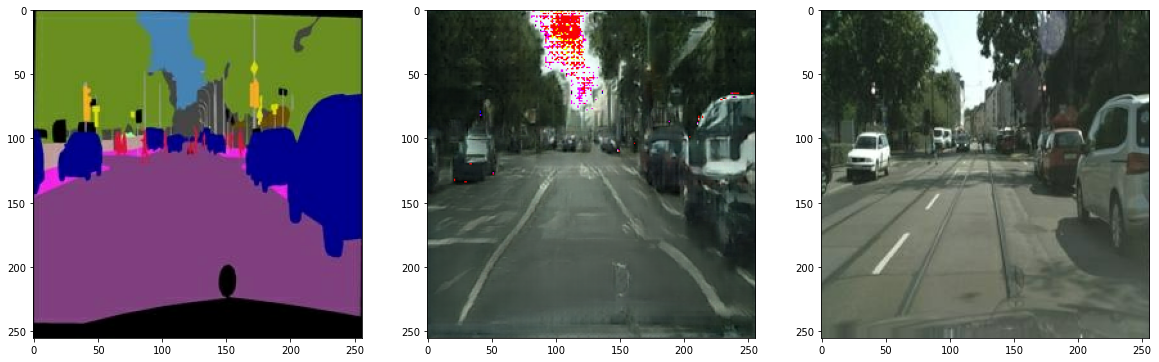

In [31]:
test_ind = 1

f = val_data_path + os.listdir(val_data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

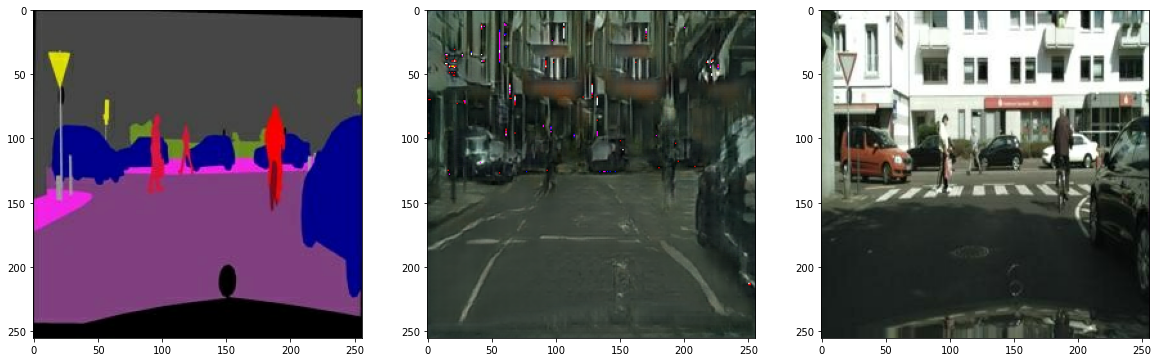

In [32]:
test_ind = 2

f = val_data_path + os.listdir(val_data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

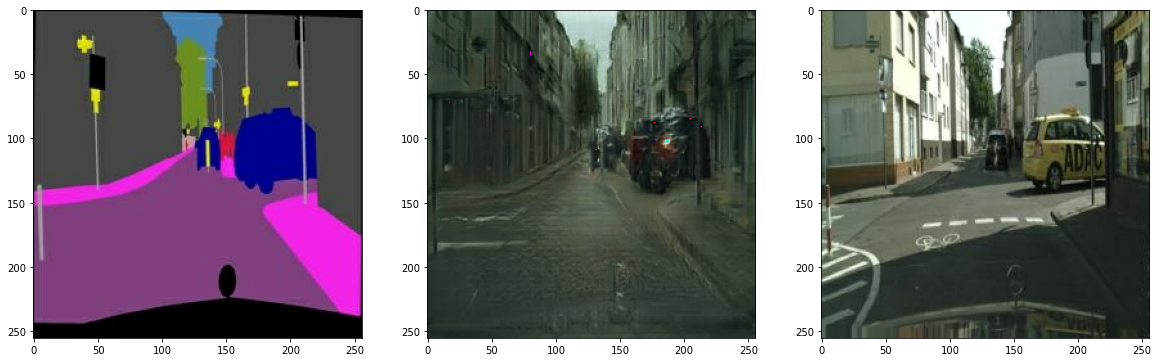

In [33]:
test_ind = 3

f = val_data_path + os.listdir(val_data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

100회 학습시켰을때 보다 더 나은 형태를 보이는 것 같습니다.